In [1]:
from google.colab import drive
import os
import sys

drive.mount('/content/drive')

# Project paths
PROJECT_PATH = '/content/drive/MyDrive/SVGEditor'
CODE_PATH = f"{PROJECT_PATH}/code"
MODEL_PATH = f"{PROJECT_PATH}/models/qwen-image-edit"
OUTPUT_PATH = f"{PROJECT_PATH}/output"

if CODE_PATH not in sys.path:
    sys.path.insert(0, CODE_PATH)

# Batch targets configuration (only target names)
targets = [
    "41_A",
    "41_B",
    "65_A",
    "65_B",
    "153_A",
    "153_B",
    "254_A",
    "254_B",
    "710_A",
    "710_B",
    "1061_A",
    "1061_B"
]

# Create output directories for all targets
for target_name in targets:
    target_output_path = f"{OUTPUT_PATH}/{target_name}"
    os.makedirs(target_output_path, exist_ok=True)

print(f"Initialized {len(targets)} targets for batch processing")
print(f"Targets: {', '.join(targets)}")

Mounted at /content/drive
Initialized 12 targets for batch processing
Targets: 41_A, 41_B, 65_A, 65_B, 153_A, 153_B, 254_A, 254_B, 710_A, 710_B, 1061_A, 1061_B


In [2]:
%pip install accelerate safetensors huggingface_hub segment-anything \
            opencv-python pillow matplotlib scikit-image scikit-learn cairosvg moviepy \
            shapely networkx lxml skan rdp openai requests lpips

!pip install -q git+https://github.com/huggingface/diffusers.git transformers>=4.51.0

import shutil
import subprocess

# Clean and clone repository
if os.path.exists(CODE_PATH):
    shutil.rmtree(CODE_PATH)

os.chdir(PROJECT_PATH)
result = subprocess.run(['git', 'clone', 'https://github.com/huanbasara/SVGEditor.git', 'code'],
                       capture_output=True, text=True)
print(f"Repository {'successfully' if result.returncode == 0 else 'failed'} cloned")

# Display latest commit info
os.chdir(CODE_PATH)
commit_info = subprocess.run(['git', 'log', '-1', '--pretty=format:%ci|%s'],
                           capture_output=True, text=True)

if commit_info.returncode == 0:
    commit_time, commit_msg = commit_info.stdout.strip().split('|', 1)
    print(f"Latest commit: {commit_time.split()[0]} - {commit_msg}")

# Add to Python path and reload modules
if CODE_PATH not in sys.path:
    sys.path.insert(0, CODE_PATH)

# Clear custom modules from cache
for base in ['sam_processor', 'svglib', 'utils']:
    to_remove = [m for m in sys.modules if m.startswith(base)]
    for m in to_remove:
        del sys.modules[m]

print("Setup complete!")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.0/95.0 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.6/100.6 kB 10.5 MB/s eta 0:00:00
  Created wheel for rdp: filename=rdp-0.8-py3-none-any.whl size=4585 sha256=aced71ccb9f2bd9d10f09a621a19fdd437279a63ad8221856ec4f49ea3697447
  Stored in directory: /root/.cache/pip/wheels/3e/80/75/e2f0e8372fde60e3be87cc64b088e10b6ed78589719d69653e
Successfully built rdp
Repository successfully cloned
Latest commit: 2025-10-14 - opt Diffusion evaluation.
Setup complete!


In [3]:
# ==================== Cell 2: Batch Image Editing with Qwen ====================
import torch
import gc
import time
from PIL import Image
from diffusers import QwenImageEditPipeline
from utils.prompt_utils import get_prompt, get_negative_prompt
from utils.plot_utils import plot_images

def load_qwen_model():
    """Load Qwen image editing model"""
    print("Clearing GPU memory...")
    torch.cuda.empty_cache()
    gc.collect()

    print("Loading model...")
    start_time = time.time()

    pipeline = QwenImageEditPipeline.from_pretrained(
        MODEL_PATH,
        local_files_only=True,
        torch_dtype=torch.bfloat16
    )
    pipeline.set_progress_bar_config(disable=None)
    pipeline.enable_model_cpu_offload()

    load_time = time.time() - start_time
    print(f"✅ Model loaded with CPU offload, time: {load_time:.2f}s")
    return pipeline, load_time

def process_image_with_qwen(pipeline, image, prompt, negative_prompt, target_name, target_output_path):
    """Process image with Qwen model"""
    # Force convert to RGB
    if image.mode == 'P':
        image = image.convert('RGBA')
    if image.mode in ('RGBA', 'LA'):
        background = Image.new('RGB', image.size, (255, 255, 255))
        background.paste(image, mask=image.split()[-1])
        image = background
    elif image.mode != 'RGB':
        image = image.convert('RGB')

    inputs = {
        "image": image,
        "prompt": prompt,
        "generator": torch.manual_seed(0),
        "true_cfg_scale": 4.0,
        "negative_prompt": negative_prompt,
        "num_inference_steps": 30,
    }

    print("Starting inference...")
    start_time = time.time()

    with torch.inference_mode():
        output = pipeline(**inputs)
        output_image = output.images[0]

    inference_time = time.time() - start_time
    print(f"Inference completed, time: {inference_time:.2f}s")

    output_path = f"{target_output_path}/{target_name}_qwen_edit.png"
    output_image.save(output_path)
    print(f"Edited image saved: {output_path}")

    return output_image, inference_time

# Load model once
pipeline, model_load_time = load_qwen_model()

# Process all targets
total_inference_time = 0
inference_times = []

for target_name in targets:
    print(f"\n{'='*60}")
    print(f"Processing: {target_name}")
    print(f"{'='*60}")

    target_output_path = f"{OUTPUT_PATH}/{target_name}"
    input_image_path = f"{CODE_PATH}/resource/{target_name}.png"

    original_image = Image.open(input_image_path)
    edit_prompt = get_prompt(target_name)
    negative_prompt = get_negative_prompt()

    print(f"Edit prompt: {edit_prompt}")
    print(f"Negative prompt: {negative_prompt}")

    try:
        edited_image, inference_time = process_image_with_qwen(
            pipeline, original_image, edit_prompt, negative_prompt,
            target_name, target_output_path
        )
        plot_images([(original_image, "Original"), (edited_image, "Edited")])

        total_inference_time += inference_time
        inference_times.append(inference_time)

    except Exception as e:
        print(f"❌ Failed: {target_name} - {str(e)}")
        continue

# Print timing summary
print(f"\n{'='*60}")
print("TIMING SUMMARY")
print(f"{'='*60}")
print(f"Model loading time: {model_load_time:.2f}s")
print(f"Total inference time: {total_inference_time:.2f}s")
print(f"Average inference time: {total_inference_time/len(inference_times):.2f}s")
print(f"Processed targets: {len(inference_times)}")

Output hidden; open in https://colab.research.google.com to view.

In [10]:
# Cleanup
del pipeline
torch.cuda.empty_cache()
gc.collect()
print("Model cleaned up, GPU memory released")

Model cleaned up, GPU memory released


In [4]:
# ==================== Cell 4: Batch Image Preprocessing ====================
import cv2
import numpy as np
from PIL import Image
import os
import time
from utils.plot_utils import plot_images
from utils.image_utils import uniform_line_thickness

# Processing parameters
BINARY_THRESHOLD = 210
THICKNESS_THRESHOLD = 5
MIN_FILL_AREA = 300
OUTLINE_WIDTH = 2
TARGET_WIDTH = 2
PRESERVE_THRESHOLD = 0.5

def convert_fills_to_outlines(binary_img):
    """Convert thick filled regions to outline borders"""
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (THICKNESS_THRESHOLD, THICKNESS_THRESHOLD))
    eroded = cv2.erode(binary_img, kernel)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(eroded)

    result_img = binary_img.copy()
    processed_count = 0

    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if area < MIN_FILL_AREA:
            continue

        component_mask = (labels == i).astype(np.uint8) * 255
        dilated_mask = cv2.dilate(component_mask, kernel)
        original_fill = cv2.bitwise_and(binary_img, dilated_mask)
        outline_mask = create_outline_from_fill(original_fill)

        result_img = cv2.bitwise_and(result_img, cv2.bitwise_not(dilated_mask))
        result_img = cv2.bitwise_or(result_img, outline_mask)
        processed_count += 1

    if processed_count > 0:
        print(f"  Processed {processed_count} filled regions")
    return result_img

def create_outline_from_fill(fill_mask):
    """Generate outline from fill region"""
    contours, _ = cv2.findContours(fill_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    outline_mask = np.zeros_like(fill_mask)
    for contour in contours:
        cv2.drawContours(outline_mask, [contour], -1, 255, thickness=OUTLINE_WIDTH)
    return outline_mask

def process_single_target_preprocessing(target_name):
    """Process preprocessing for a single target"""
    target_output_path = f"{OUTPUT_PATH}/{target_name}"
    input_path = os.path.join(target_output_path, f"{target_name}_qwen_edit.png")

    if not os.path.exists(input_path):
        print(f"  ERROR: Input file not found: {input_path}")
        return None

    step_times = {}

    # Load image
    t0 = time.time()
    img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    step_times['load'] = time.time() - t0

    # Step 1: Binarization
    t1 = time.time()
    _, binary = cv2.threshold(img, BINARY_THRESHOLD, 255, cv2.THRESH_BINARY_INV)
    step_times['binarization'] = time.time() - t1

    # Step 2: Fill-to-outline conversion
    t2 = time.time()
    step1_result = convert_fills_to_outlines(binary)
    step_times['fill_to_outline'] = time.time() - t2

    # Step 3: Uniform line thickness
    t3 = time.time()
    step2_result = uniform_line_thickness(
        step1_result,
        target_width=TARGET_WIDTH,
        preserve_threshold=PRESERVE_THRESHOLD
    )
    step_times['uniform_thickness'] = time.time() - t3

    # Save intermediate files
    t4 = time.time()
    cv2.imwrite(os.path.join(target_output_path, f"{target_name}_0_original.png"), img)
    cv2.imwrite(os.path.join(target_output_path, f"{target_name}_1_binary.png"), binary)
    cv2.imwrite(os.path.join(target_output_path, f"{target_name}_2_outline.png"), step1_result)
    cv2.imwrite(os.path.join(target_output_path, f"{target_name}_3_uniform.png"), step2_result)
    step_times['save'] = time.time() - t4

    total_time = sum(step_times.values())
    print(f"  ✅ Completed in {total_time:.2f}s (binary: {step_times['binarization']:.2f}s, outline: {step_times['fill_to_outline']:.2f}s, uniform: {step_times['uniform_thickness']:.2f}s)")

    return {
        'original': img,
        'binary': binary,
        'step1_outline': step1_result,
        'step2_uniform': step2_result
    }

# Batch process all targets
print("="*60)
print("BATCH IMAGE PREPROCESSING")
print("="*60)
print(f"Processing {len(targets)} targets")
print(f"Parameters: threshold={BINARY_THRESHOLD}, width={TARGET_WIDTH}px")
print("="*60)

batch_start_time = time.time()

for idx, target_name in enumerate(targets, 1):
    print(f"\n[{idx}/{len(targets)}] Preprocessing: {target_name}")

    target_start = time.time()
    results = process_single_target_preprocessing(target_name)

    # Visualize each target
    if results is not None:
        images_to_plot = [
            (Image.fromarray(results['original']).convert('RGB'), "0. Original"),
            (Image.fromarray(results['binary']).convert('RGB'), "1. Binary"),
            (Image.fromarray(results['step1_outline']).convert('RGB'), "2. Fill→Outline"),
            (Image.fromarray(results['step2_uniform']).convert('RGB'), "3. Uniform")
        ]
        plot_images(images_to_plot)

batch_total_time = time.time() - batch_start_time

print(f"\n{'='*60}")
print(f"✅ All {len(targets)} preprocessing completed!")
print(f"Total time: {batch_total_time:.2f}s (avg: {batch_total_time/len(targets):.2f}s per target)")
print(f"{'='*60}")

Output hidden; open in https://colab.research.google.com to view.

BATCH SKELETON EXTRACTION
Processing 12 targets
Parameters: dilate=2, erode=1, blur_kernel=3

[1/12] Skeletonization: 41_A
    Connected 3 endpoints
  ✅ Completed in 2.93s (smooth: 0.00s, blur: 0.01s, skeleton: 0.04s)


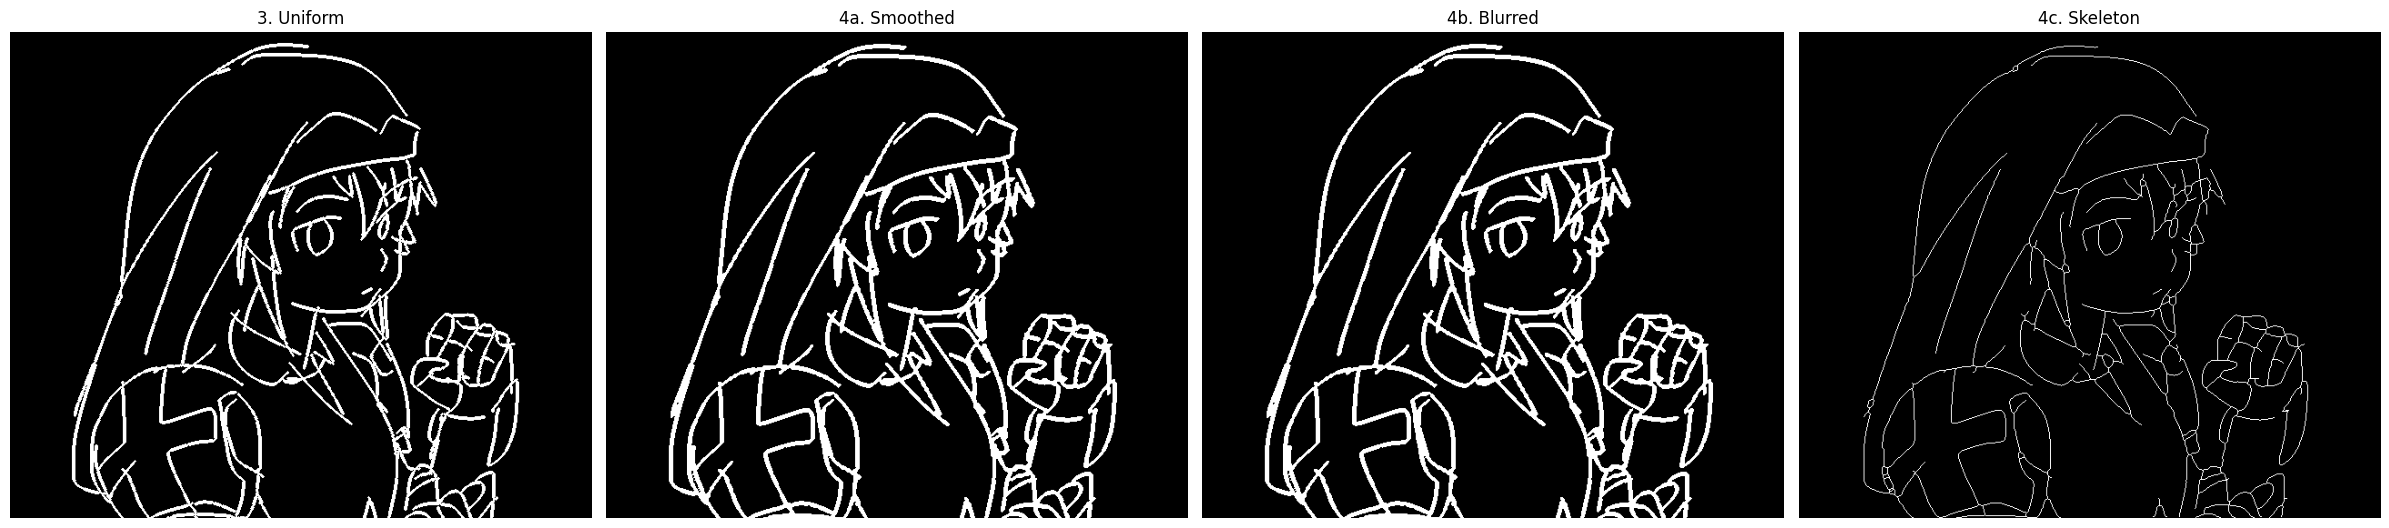


[2/12] Skeletonization: 41_B
    Connected 4 endpoints
  ✅ Completed in 2.34s (smooth: 0.00s, blur: 0.00s, skeleton: 0.02s)


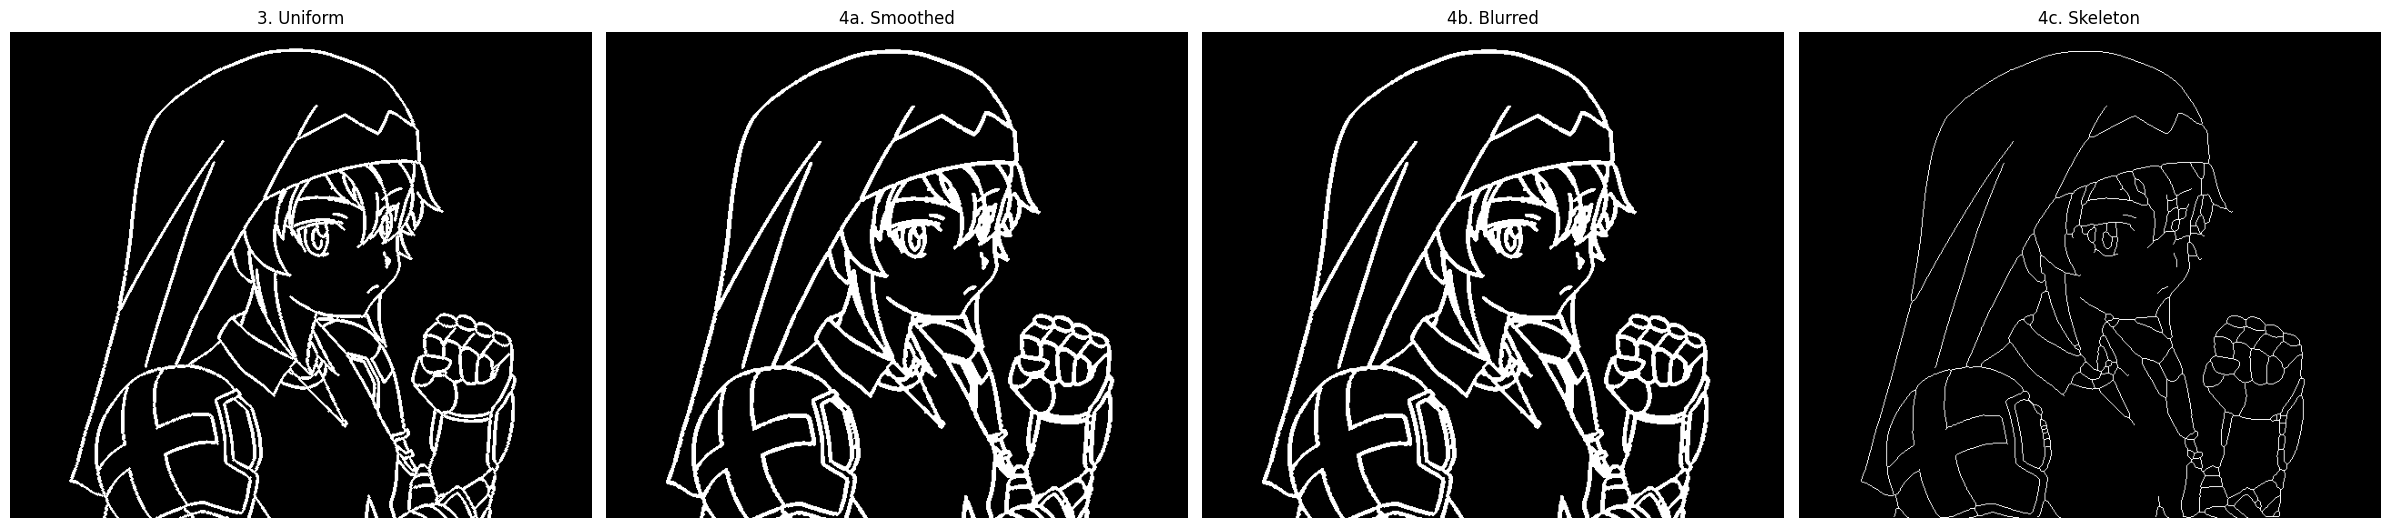


[3/12] Skeletonization: 65_A
    Connected 1 endpoints
  ✅ Completed in 2.65s (smooth: 0.00s, blur: 0.00s, skeleton: 0.09s)


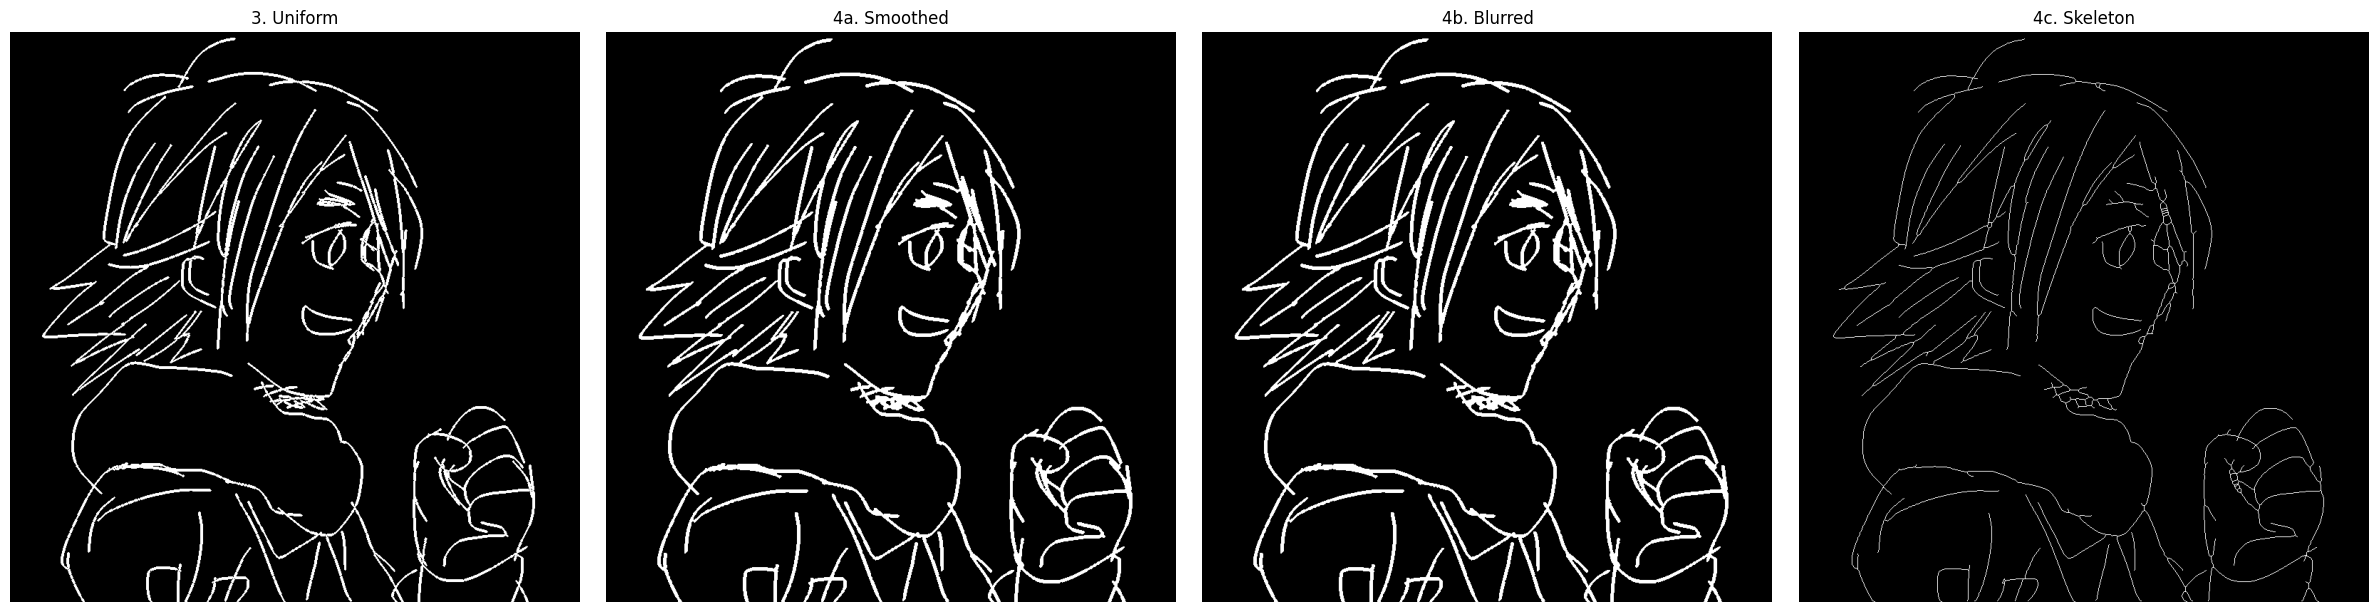


[4/12] Skeletonization: 65_B
    Connected 24 endpoints
    Removed 1 short branches
  ✅ Completed in 3.10s (smooth: 0.00s, blur: 0.00s, skeleton: 0.15s)


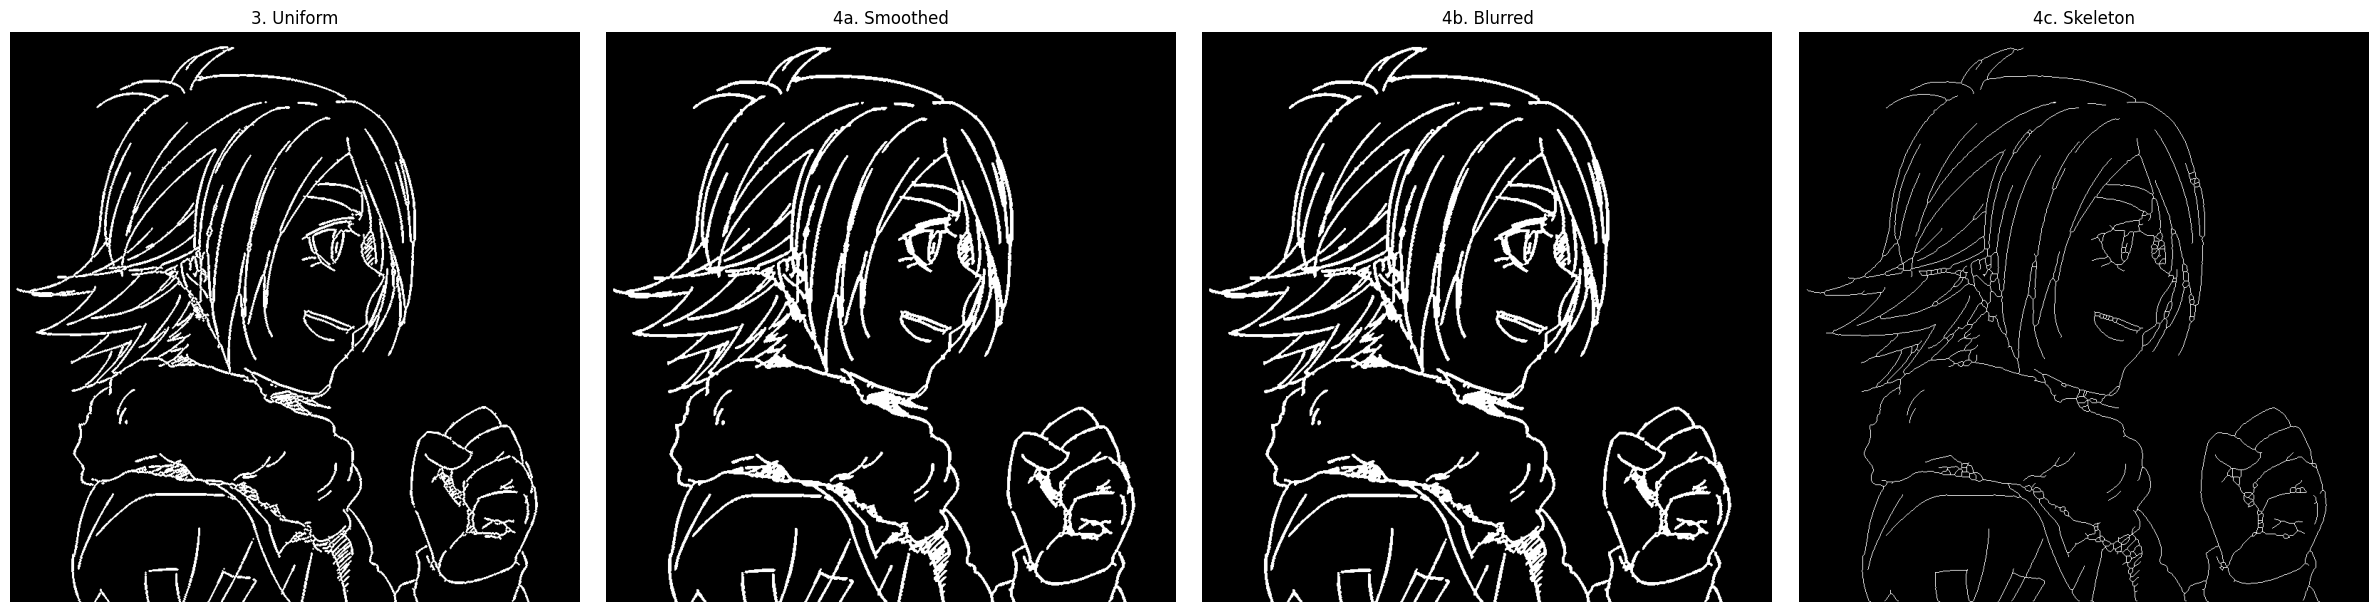


[5/12] Skeletonization: 153_A
    Connected 3 endpoints
  ✅ Completed in 4.58s (smooth: 0.00s, blur: 0.00s, skeleton: 0.08s)


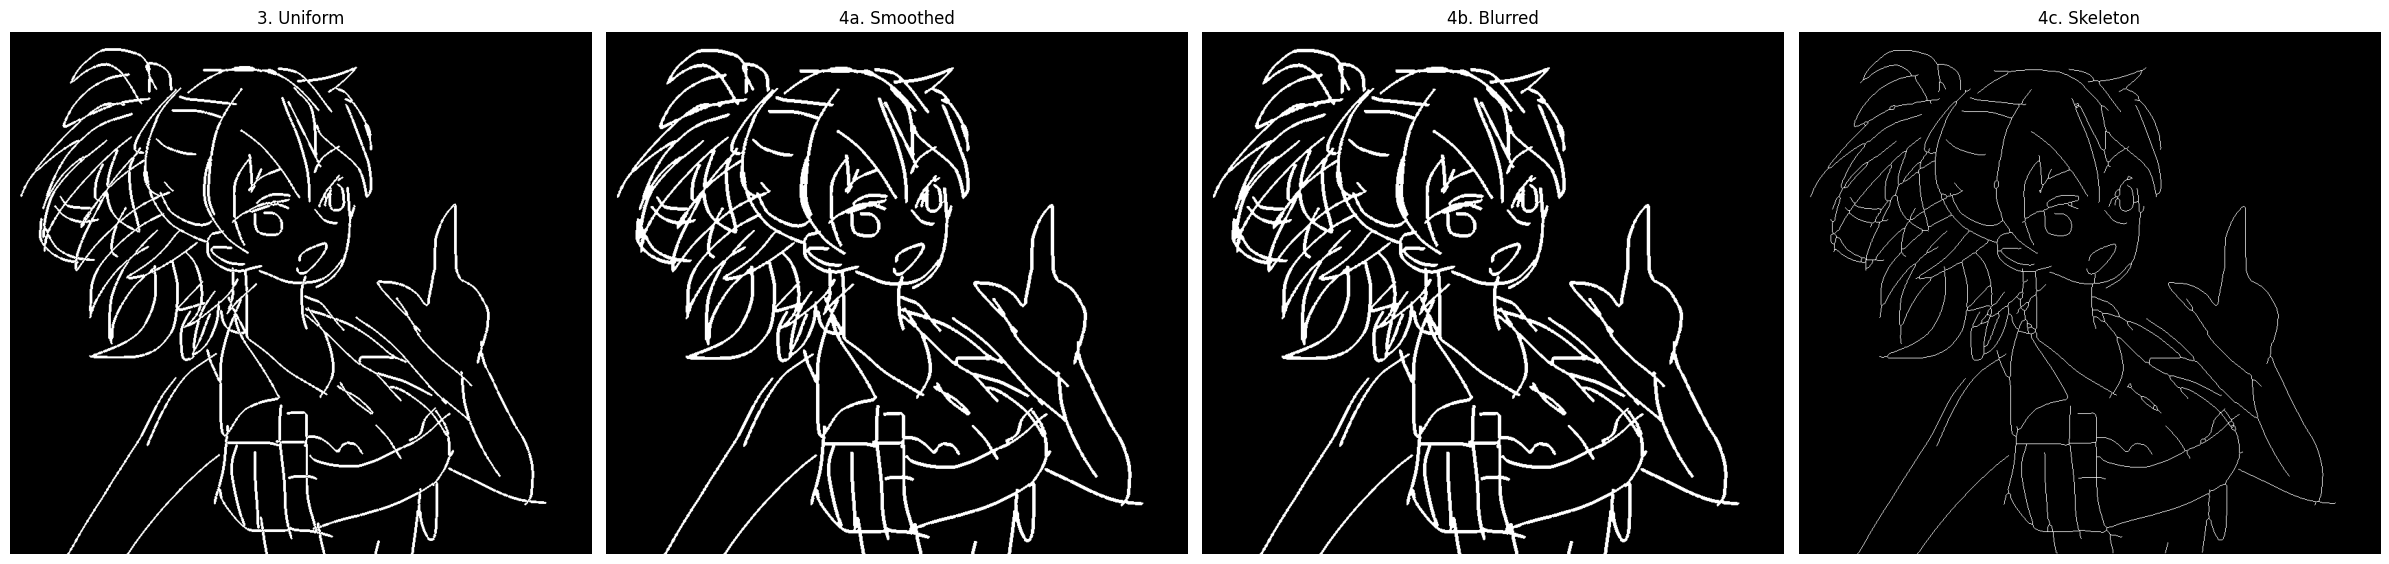


[6/12] Skeletonization: 153_B
    Connected 7 endpoints
  ✅ Completed in 3.02s (smooth: 0.00s, blur: 0.00s, skeleton: 0.07s)


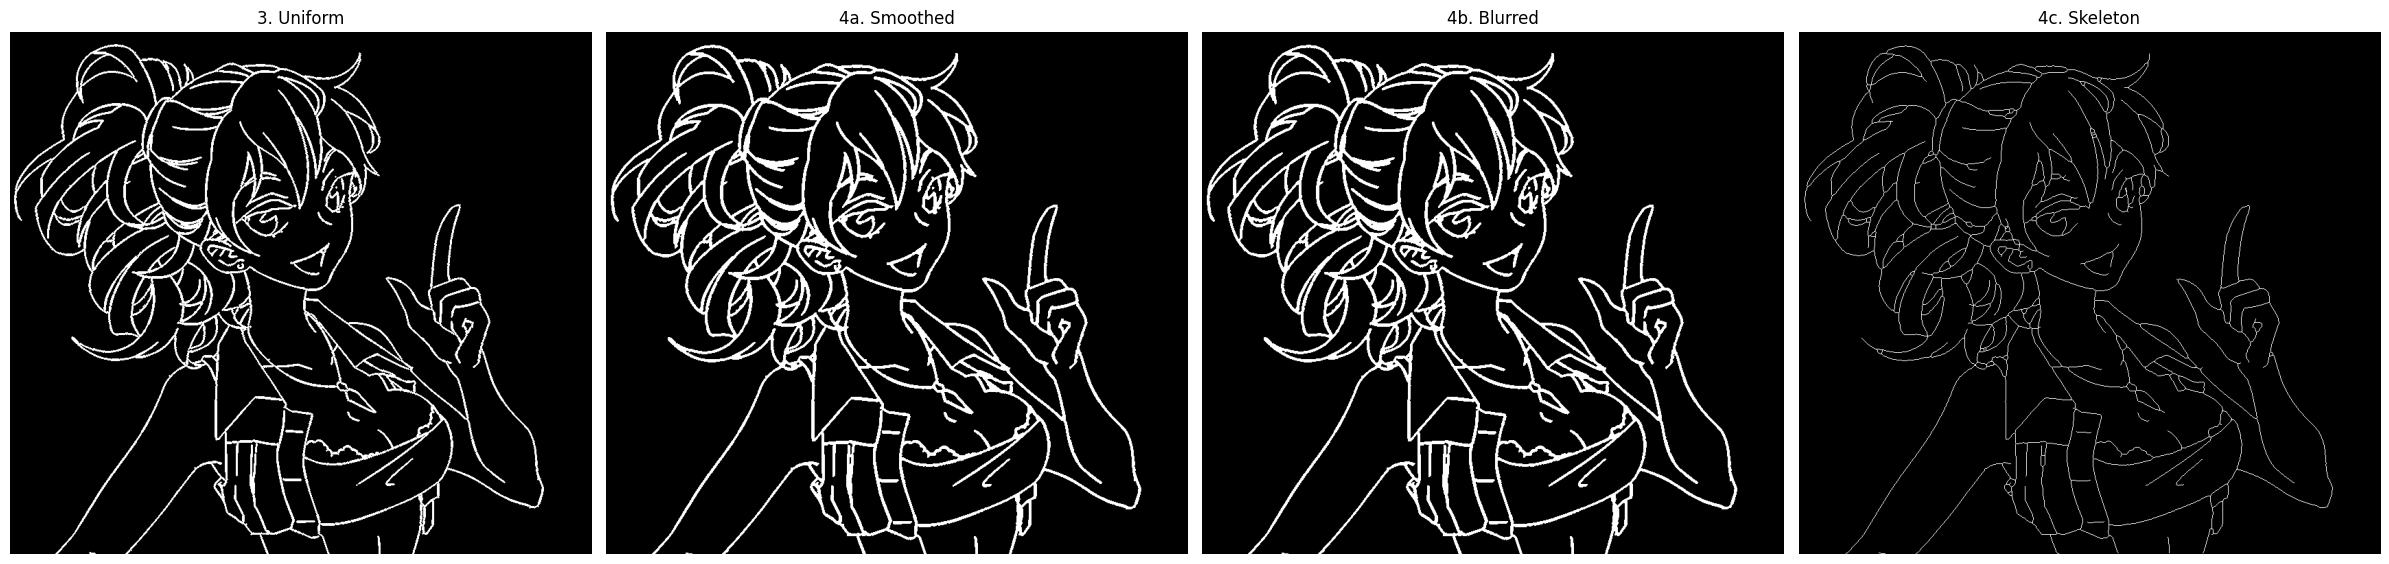


[7/12] Skeletonization: 254_A
    Connected 5 endpoints
  ✅ Completed in 2.84s (smooth: 0.00s, blur: 0.00s, skeleton: 0.09s)


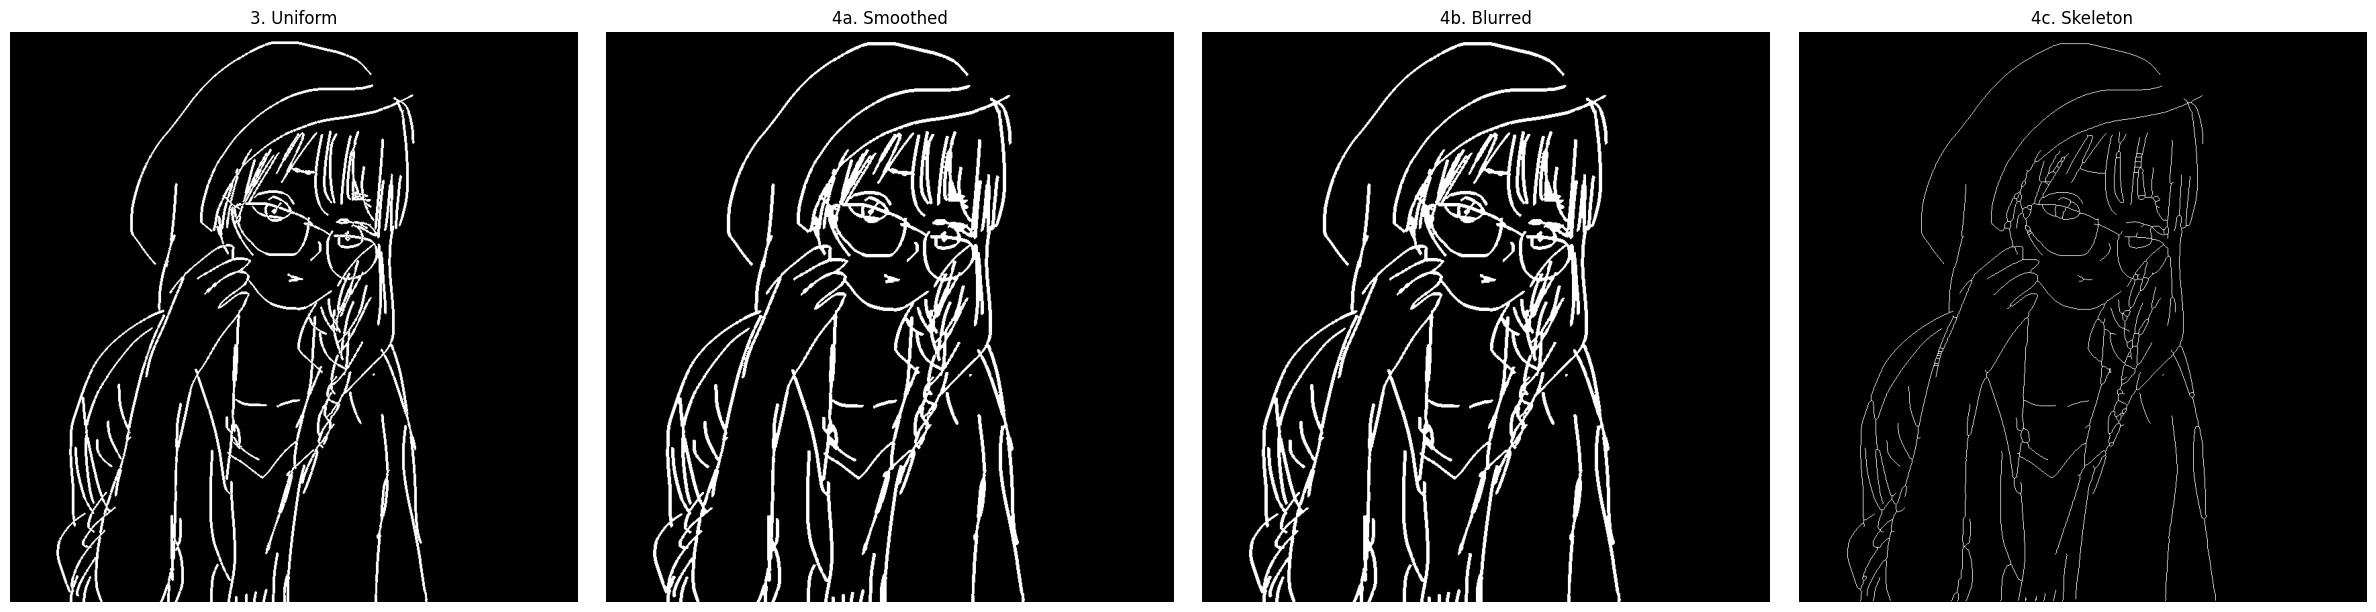


[8/12] Skeletonization: 254_B
    Connected 11 endpoints
    Removed 2 short branches
  ✅ Completed in 2.68s (smooth: 0.00s, blur: 0.00s, skeleton: 0.12s)


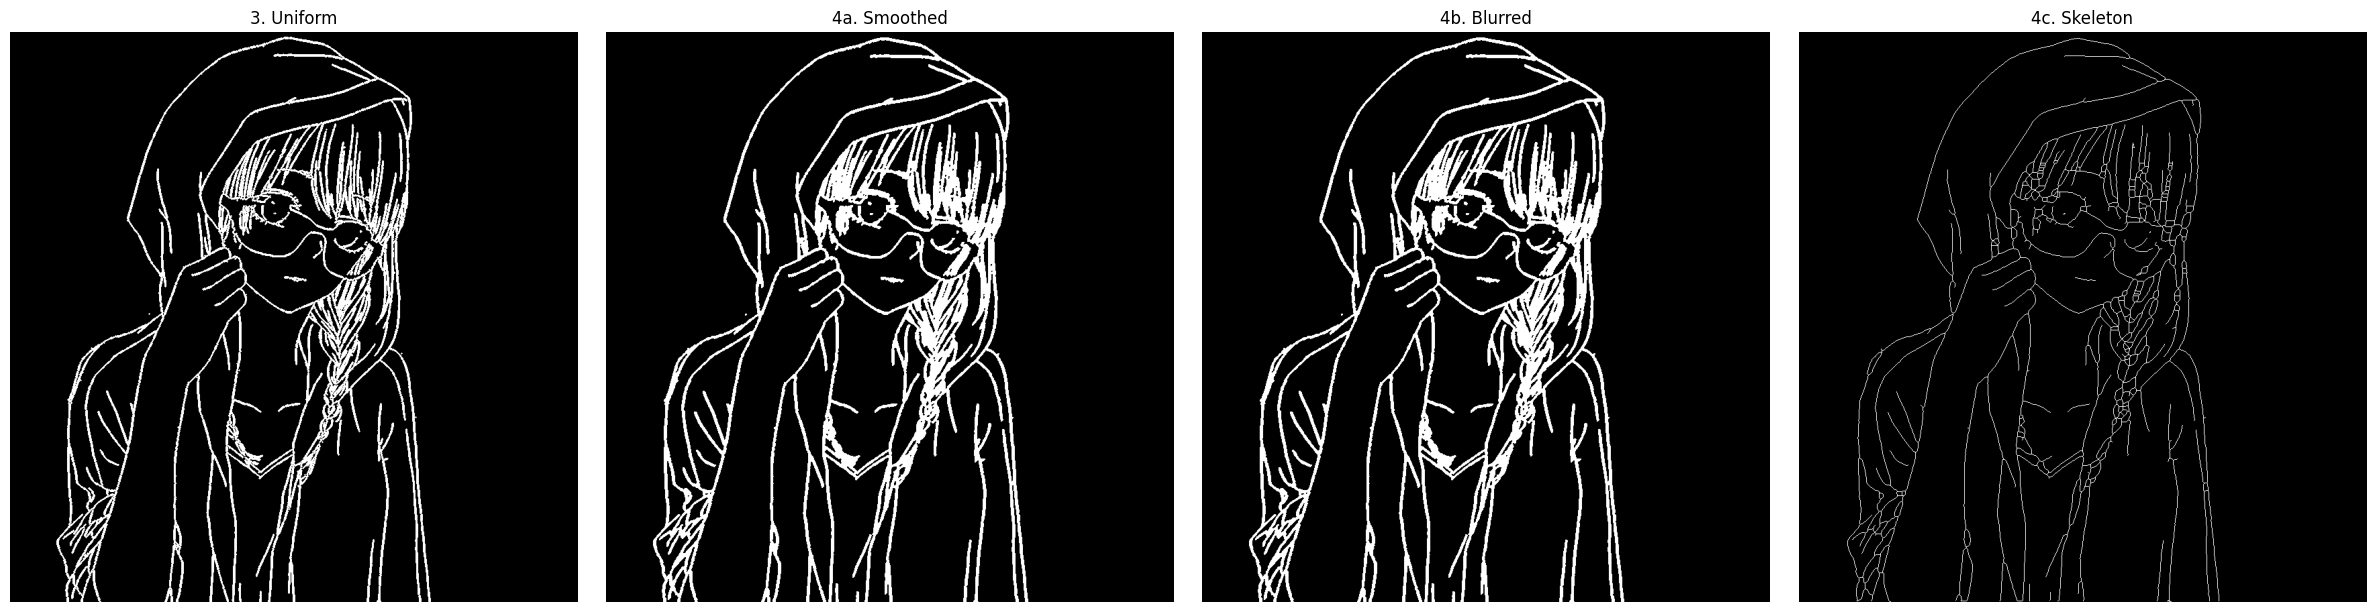


[9/12] Skeletonization: 710_A
    Connected 4 endpoints
  ✅ Completed in 2.89s (smooth: 0.00s, blur: 0.00s, skeleton: 0.09s)


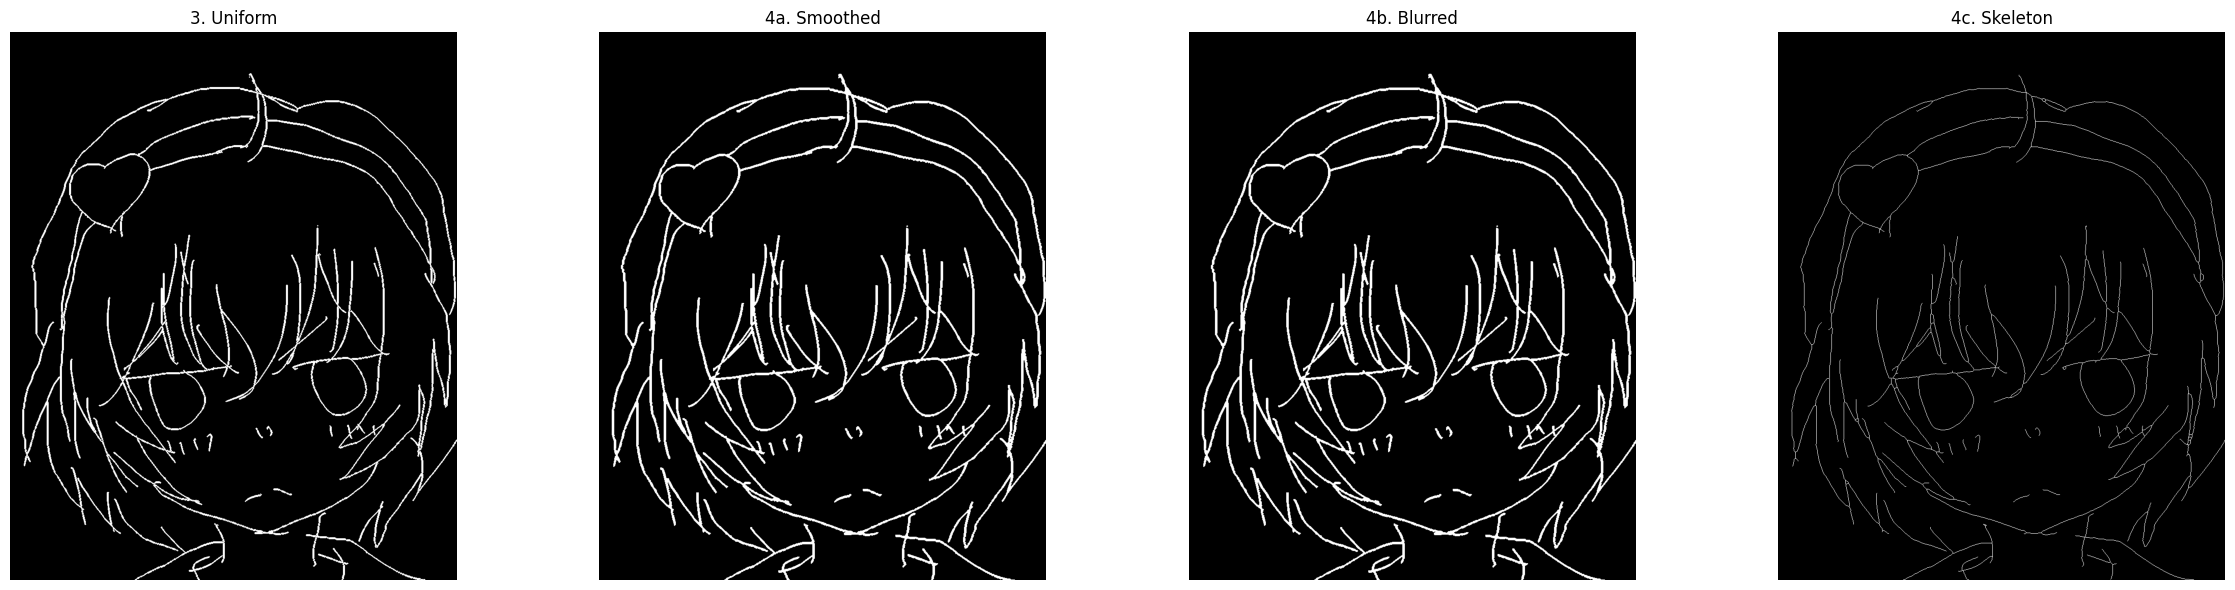


[10/12] Skeletonization: 710_B
    Connected 9 endpoints
  ✅ Completed in 3.53s (smooth: 0.00s, blur: 0.00s, skeleton: 0.10s)


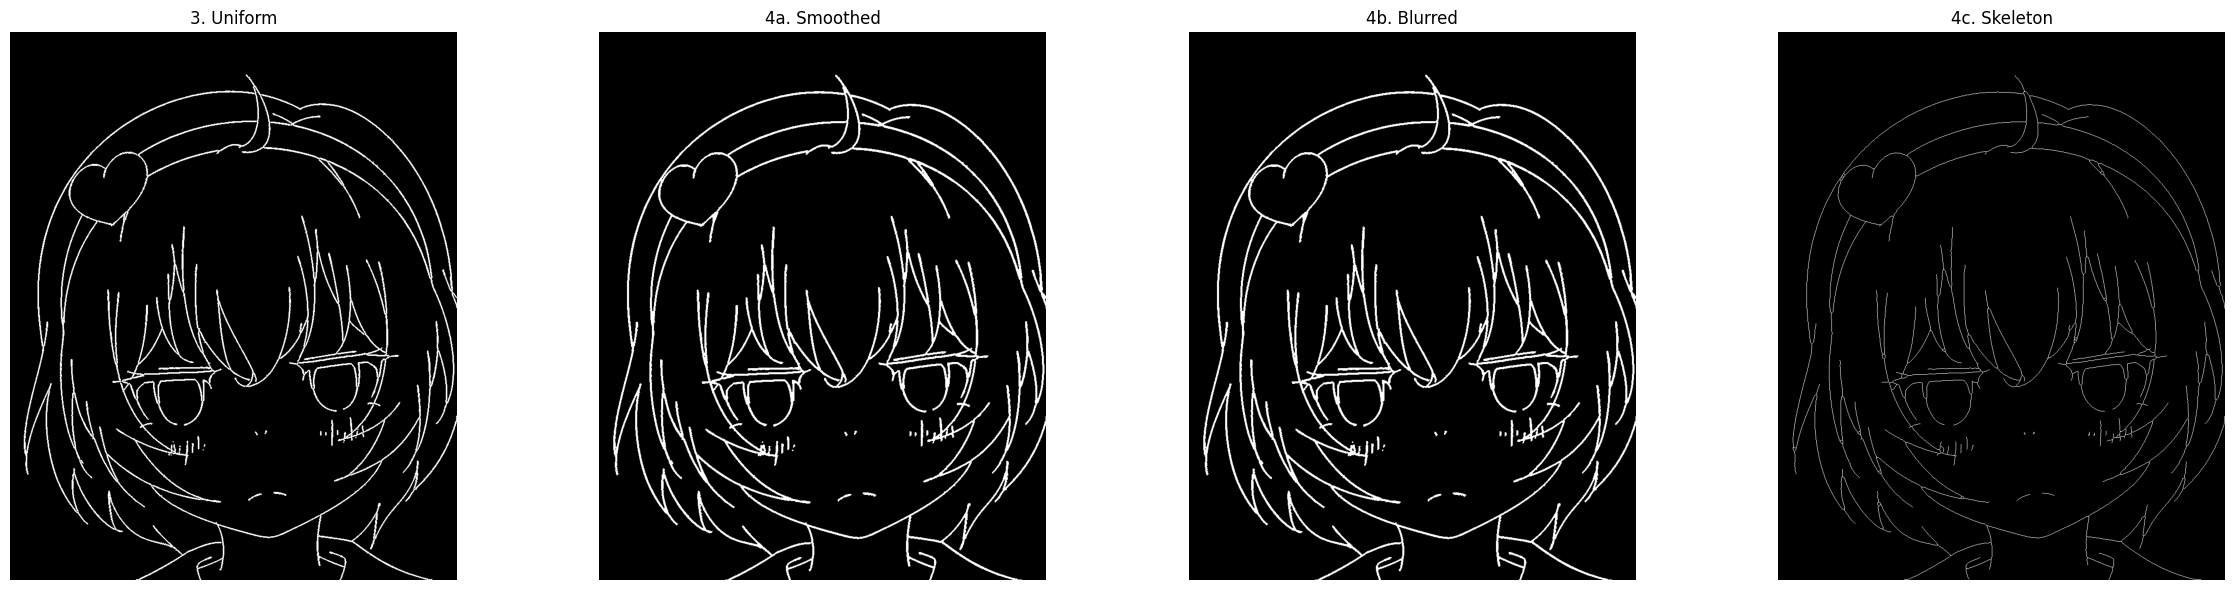


[11/12] Skeletonization: 1061_A
    Connected 10 endpoints
    Removed 1 short branches
  ✅ Completed in 2.65s (smooth: 0.00s, blur: 0.00s, skeleton: 0.07s)


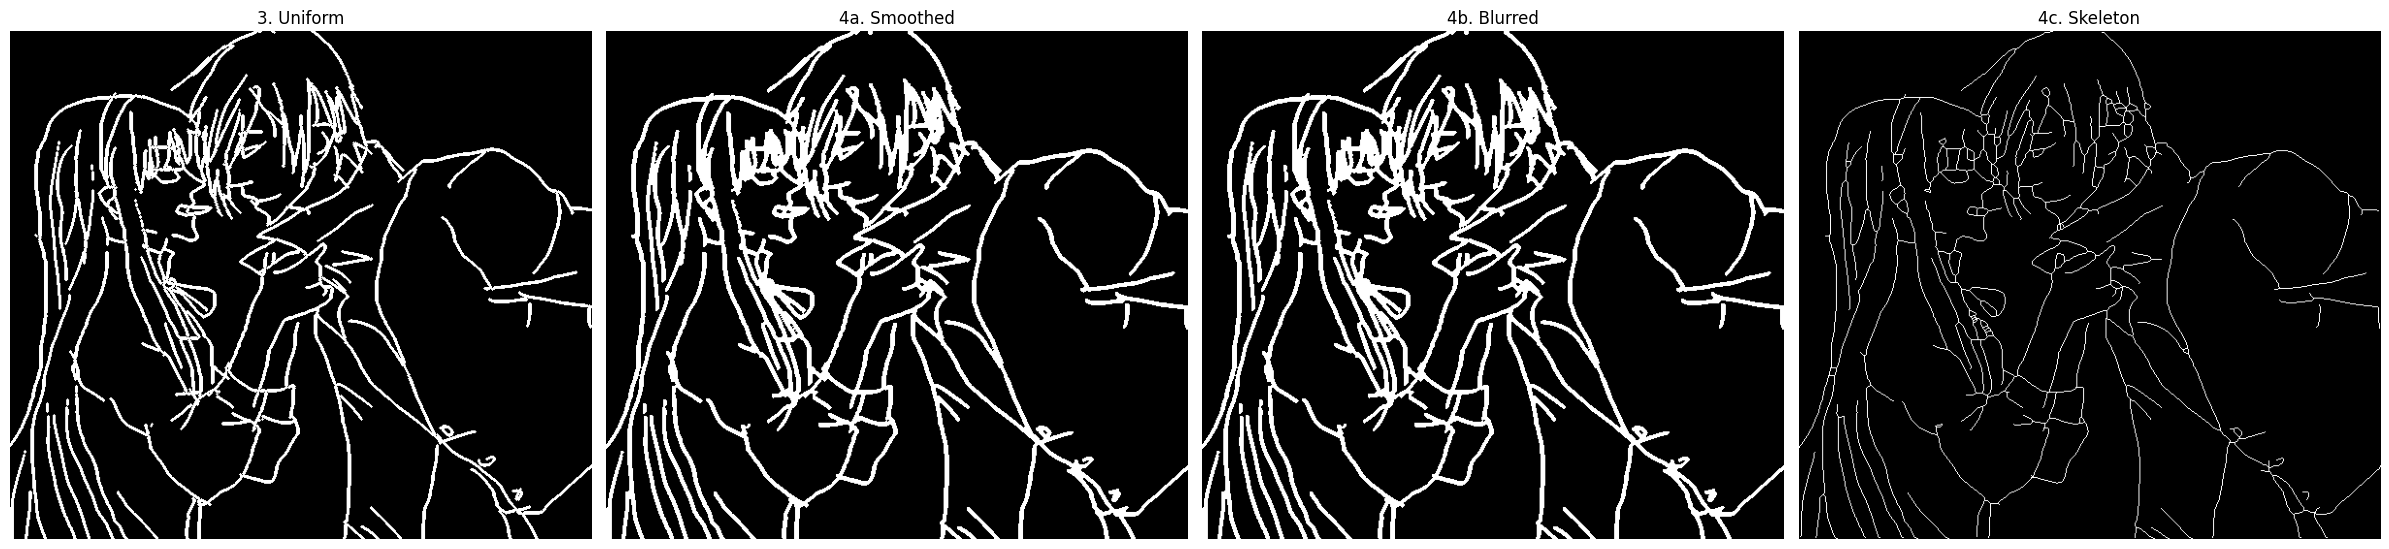


[12/12] Skeletonization: 1061_B
    Connected 5 endpoints
  ✅ Completed in 3.18s (smooth: 0.00s, blur: 0.00s, skeleton: 0.10s)


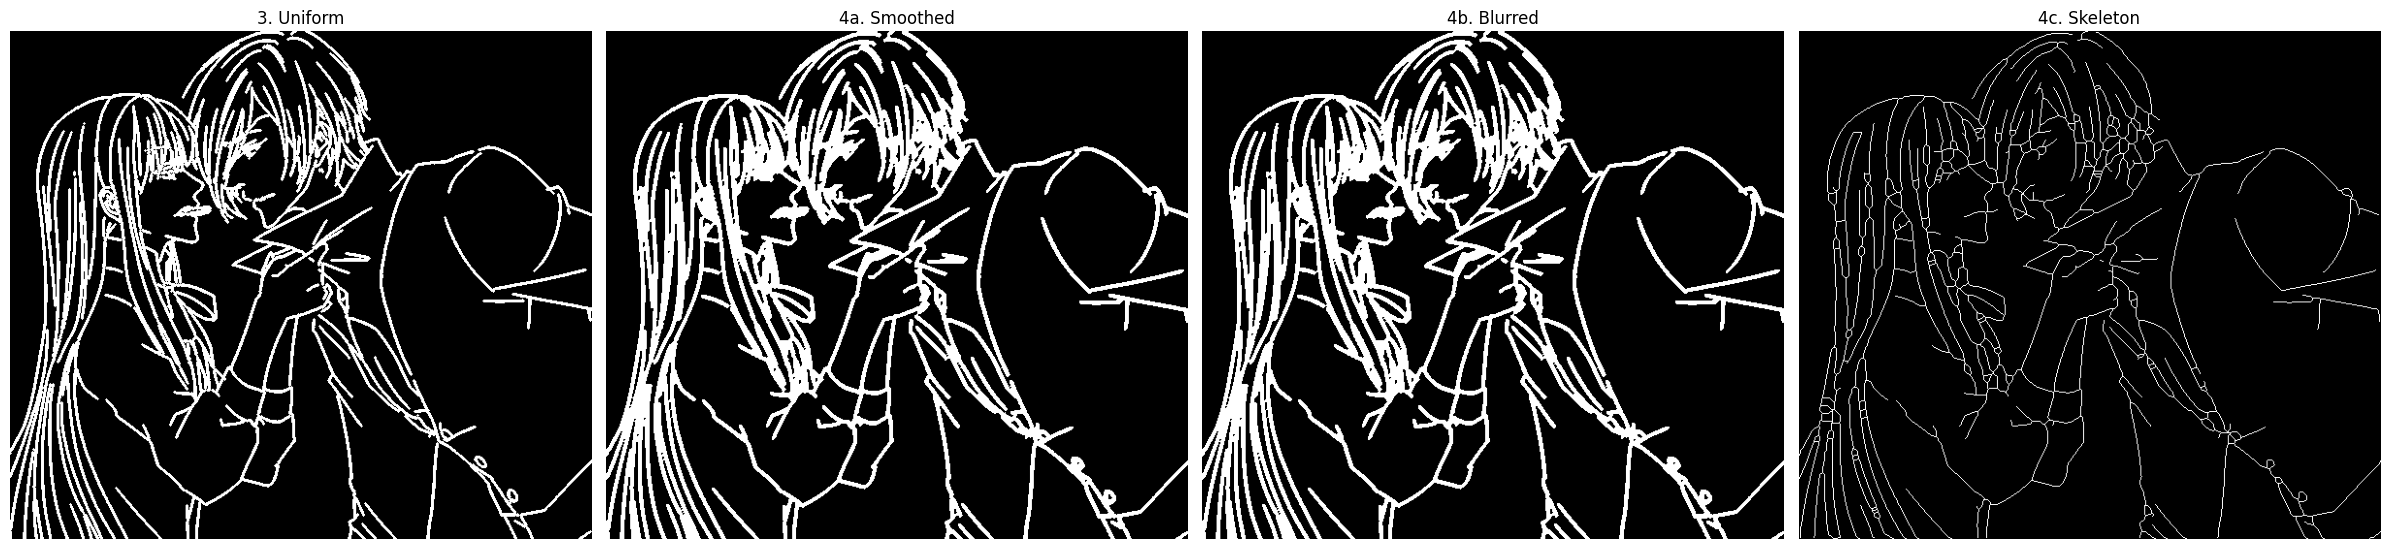


✅ All 12 skeletonization completed!
Total time: 42.77s (avg: 3.56s per target)


In [5]:
# ==================== Cell 5: Batch Skeleton Extraction ====================
import cv2
import numpy as np
from PIL import Image
from skimage.morphology import skeletonize
import os
import time
from utils.plot_utils import plot_images

# Skeletonization parameters
SKELETON_MIN_LENGTH = 3
ENDPOINT_CONNECTION_DIST = 8
SKELETON_DILATE_KERNEL = 2
SKELETON_DILATE_ITERATIONS = 2
SKELETON_ERODE_KERNEL = 2
SKELETON_ERODE_ITERATIONS = 1

# Blur parameters
BLUR_KERNEL_SIZE = 3
BLUR_SIGMA = 0.5

def apply_light_blur(binary_img):
    """Apply light Gaussian blur for skeletonization preparation"""
    # 轻微高斯模糊
    blurred = cv2.GaussianBlur(binary_img, (BLUR_KERNEL_SIZE, BLUR_KERNEL_SIZE), BLUR_SIGMA)

    # 重新二值化保持黑白
    _, result = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)

    return result

def find_skeleton_endpoints(skeleton):
    """Find skeleton endpoints"""
    kernel = np.array([[1, 1, 1],
                       [1, 10, 1],
                       [1, 1, 1]], dtype=np.uint8)

    neighbor_count = cv2.filter2D(skeleton.astype(np.uint8), -1, kernel)
    endpoints = np.where((skeleton == 1) & (neighbor_count == 11))

    return list(zip(endpoints[0], endpoints[1]))

def connect_nearby_endpoints(skeleton):
    """Connect endpoints that are close to each other"""
    endpoints = find_skeleton_endpoints(skeleton)
    result = skeleton.astype(np.uint8)
    connections_made = 0

    for i, ep1 in enumerate(endpoints):
        for ep2 in endpoints[i+1:]:
            distance = np.linalg.norm(np.array(ep1) - np.array(ep2))

            if distance <= ENDPOINT_CONNECTION_DIST:
                cv2.line(result, ep1[::-1], ep2[::-1], 1, 1)
                connections_made += 1

    if connections_made > 0:
        print(f"    Connected {connections_made} endpoints")
    return result.astype(bool)

def remove_short_branches(skeleton, min_length=None):
    """Remove short skeleton branches"""
    if min_length is None:
        min_length = SKELETON_MIN_LENGTH

    num_labels, labels = cv2.connectedComponents(skeleton.astype(np.uint8))
    result = np.zeros_like(skeleton)
    removed_count = 0

    for i in range(1, num_labels):
        component = (labels == i)
        component_size = np.sum(component)

        if component_size >= min_length:
            result[component] = 1
        else:
            removed_count += 1

    if removed_count > 0:
        print(f"    Removed {removed_count} short branches")
    return result

def extract_skeleton(binary_img):
    """Extract skeleton from binary image"""
    skeleton = skeletonize(binary_img > 0)
    skeleton_connected = connect_nearby_endpoints(skeleton)
    skeleton_cleaned = remove_short_branches(skeleton_connected)
    return skeleton_cleaned

def smooth_skeleton_asymmetric(skeleton_img):
    """Asymmetric smoothing"""
    dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                                              (SKELETON_DILATE_KERNEL, SKELETON_DILATE_KERNEL))
    dilated = cv2.dilate(skeleton_img, dilate_kernel, iterations=SKELETON_DILATE_ITERATIONS)

    erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                                             (SKELETON_ERODE_KERNEL, SKELETON_ERODE_KERNEL))
    smoothed = cv2.erode(dilated, erode_kernel, iterations=SKELETON_ERODE_ITERATIONS)

    return smoothed

def process_single_target_skeletonization(target_name):
    """Process skeletonization for a single target"""
    target_output_path = f"{OUTPUT_PATH}/{target_name}"
    input_path = os.path.join(target_output_path, f"{target_name}_3_uniform.png")

    if not os.path.exists(input_path):
        print(f"  ERROR: Input file not found")
        return None

    step_times = {}

    # Load image
    t0 = time.time()
    img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    step_times['load'] = time.time() - t0

    # Phase 1: Smooth the image (dilate + erode)
    t1 = time.time()
    img_smoothed = smooth_skeleton_asymmetric(img)
    step_times['smooth'] = time.time() - t1

    # Phase 2: Apply light blur for better skeletonization
    t2 = time.time()
    img_blurred = apply_light_blur(img_smoothed)
    step_times['blur'] = time.time() - t2

    # Phase 3: Extract skeleton (only once)
    t3 = time.time()
    skeleton_final = extract_skeleton(img_blurred)
    skeleton_final_uint8 = (skeleton_final * 255).astype(np.uint8)
    step_times['skeleton'] = time.time() - t3

    # Distance transform
    t4 = time.time()
    distance_transform = cv2.distanceTransform(img, cv2.DIST_L2, 5)
    distance_normalized = cv2.normalize(distance_transform, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    step_times['distance_transform'] = time.time() - t4

    # Save results
    t5 = time.time()
    cv2.imwrite(os.path.join(target_output_path, f"{target_name}_4_smoothed.png"), img_smoothed)
    cv2.imwrite(os.path.join(target_output_path, f"{target_name}_4_blurred.png"), img_blurred)
    cv2.imwrite(os.path.join(target_output_path, f"{target_name}_4_skeleton_final.png"), skeleton_final_uint8)
    cv2.imwrite(os.path.join(target_output_path, f"{target_name}_4_distance.png"), distance_normalized)
    step_times['save'] = time.time() - t5

    total_time = sum(step_times.values())
    print(f"  ✅ Completed in {total_time:.2f}s (smooth: {step_times['smooth']:.2f}s, blur: {step_times['blur']:.2f}s, skeleton: {step_times['skeleton']:.2f}s)")

    return {
        'uniform': img,
        'smoothed': img_smoothed,
        'blurred': img_blurred,
        'skeleton_final': skeleton_final_uint8,
        'distance_transform': distance_normalized
    }

# Batch process all targets
print("="*60)
print("BATCH SKELETON EXTRACTION")
print("="*60)
print(f"Processing {len(targets)} targets")
print(f"Parameters: dilate={SKELETON_DILATE_ITERATIONS}, erode={SKELETON_ERODE_ITERATIONS}, blur_kernel={BLUR_KERNEL_SIZE}")
print("="*60)

batch_start_time = time.time()

for idx, target_name in enumerate(targets, 1):
    print(f"\n[{idx}/{len(targets)}] Skeletonization: {target_name}")

    results = process_single_target_skeletonization(target_name)

    # Visualize each target
    if results is not None:
        images_to_plot = [
            (Image.fromarray(results['uniform']).convert('RGB'), "3. Uniform"),
            (Image.fromarray(results['smoothed']).convert('RGB'), "4a. Smoothed"),
            (Image.fromarray(results['blurred']).convert('RGB'), "4b. Blurred"),
            (Image.fromarray(results['skeleton_final']).convert('RGB'), "4c. Skeleton"),
        ]
        plot_images(images_to_plot)

batch_total_time = time.time() - batch_start_time

print(f"\n{'='*60}")
print(f"✅ All {len(targets)} skeletonization completed!")
print(f"Total time: {batch_total_time:.2f}s (avg: {batch_total_time/len(targets):.2f}s per target)")
print(f"{'='*60}")

In [24]:
# ==================== Cell 6: Batch Skeleton to SVG Conversion ====================
import cv2
import numpy as np
from skimage.measure import label, regionprops
from svglib.svg import SVG
from svglib.svg_path import SVGPath
from svglib.svg_primitive import SVGPathGroup
from svglib.geom import Bbox
from utils.plot_utils import plot_images
from utils.image_utils import svg_code_to_pil_image
import os
import time
import re

def count_svg_commands(svg_code):
    """Count different SVG path commands"""
    commands = {
        'M': len(re.findall(r'M\s*[-\d.]+', svg_code)),
        'L': len(re.findall(r'L\s*[-\d.]+', svg_code)),
        'C': len(re.findall(r'C\s*[-\d.]+', svg_code)),
        'Q': len(re.findall(r'Q\s*[-\d.]+', svg_code)),
        'Z': len(re.findall(r'Z', svg_code)),
        'H': len(re.findall(r'H\s*[-\d.]+', svg_code)),
        'V': len(re.findall(r'V\s*[-\d.]+', svg_code)),
        'S': len(re.findall(r'S\s*[-\d.]+', svg_code)),
        'A': len(re.findall(r'A\s*[-\d.]+', svg_code)),
    }
    total = sum(commands.values())
    return commands, total

def get_svg_stats(svg_path, svg_code):
    """Get comprehensive SVG statistics"""
    file_size = os.path.getsize(svg_path)
    num_paths = svg_code.count('<path')
    commands, total_commands = count_svg_commands(svg_code)

    # Filter out commands with 0 count
    active_commands = {k: v for k, v in commands.items() if v > 0}

    return {
        'file_size': file_size,
        'num_paths': num_paths,
        'total_commands': total_commands,
        'commands': active_commands
    }

def print_svg_stats(stats, label=""):
    """Print SVG statistics in a formatted way"""
    if label:
        print(f"  {label}:")
    print(f"    Paths: {stats['num_paths']}, Commands: {stats['total_commands']}, Size: {stats['file_size']} bytes")
    cmd_str = ", ".join([f"{k}:{v}" for k, v in stats['commands'].items()])
    print(f"    Command breakdown: {cmd_str}")

def extract_paths_from_skeleton(skeleton):
    """Extract ordered paths from skeleton"""
    skeleton_binary = (skeleton > 0).astype(np.uint8)
    labeled = label(skeleton_binary)
    regions = regionprops(labeled)

    paths = []
    for region in regions:
        coords = region.coords
        if len(coords) < 2:
            continue

        # Find endpoints
        def count_neighbors(pt, all_coords):
            return sum(1 for c in all_coords
                      if abs(c[0]-pt[0]) <= 1 and abs(c[1]-pt[1]) <= 1 and tuple(c) != tuple(pt))

        endpoints = [p for p in coords if count_neighbors(p, coords) == 1]
        remaining = set(tuple(c) for c in coords)

        # Trace paths from endpoints
        while remaining:
            start = None
            for ep in endpoints:
                if tuple(ep) in remaining:
                    start = ep
                    break
            if start is None:
                start = next(iter(remaining))

            # Build path
            path_coords = [(int(start[1]), int(start[0]))]
            remaining.remove(tuple(start))
            cur = start

            while remaining:
                nxt = next((c for c in remaining
                           if abs(c[0]-cur[0]) <= 1 and abs(c[1]-cur[1]) <= 1), None)
                if nxt is None:
                    break
                path_coords.append((int(nxt[1]), int(nxt[0])))
                remaining.remove(nxt)
                cur = nxt

            if len(path_coords) >= 2:
                paths.append(path_coords)

    return paths

def convert_to_svg(paths, image_shape):
    """Convert paths to SVG"""
    svg_paths = []
    for path in paths:
        d = f"M {path[0][0]:.1f} {path[0][1]:.1f}"
        for x, y in path[1:]:
            d += f" L {x:.1f} {y:.1f}"
        path_group = SVGPath.from_str(d, add_closing=False)
        svg_paths.extend(path_group.svg_paths)

    viewbox = Bbox(0, 0, image_shape[1], image_shape[0])
    group = SVGPathGroup(svg_paths, fill=False, stroke_width=2.0)

    for sp in group.svg_paths:
        if not hasattr(sp, 'filling'):
            sp.filling = 0

    return SVG([group], viewbox=viewbox)

def process_single_target_svg_conversion(target_name):
    """Convert skeleton to SVG for a single target"""
    target_output_path = f"{OUTPUT_PATH}/{target_name}"
    skeleton_path = os.path.join(target_output_path, f"{target_name}_4_skeleton_final.png")

    if not os.path.exists(skeleton_path):
        print(f"  ERROR: Skeleton not found")
        return None

    step_times = {}

    # Load skeleton
    t0 = time.time()
    skeleton = cv2.imread(skeleton_path, cv2.IMREAD_GRAYSCALE)
    step_times['load'] = time.time() - t0

    # Extract paths
    t1 = time.time()
    paths = extract_paths_from_skeleton(skeleton)
    step_times['extract_paths'] = time.time() - t1
    print(f"  Extracted {len(paths)} paths in {step_times['extract_paths']:.2f}s")

    if not paths:
        print(f"  WARNING: No paths extracted")
        return None

    # Convert to SVG
    t2 = time.time()
    svg = convert_to_svg(paths, skeleton.shape)
    svg_path = os.path.join(target_output_path, f"{target_name}_5_raw.svg")
    svg.save_svg(svg_path, coordinate_precision=1)
    step_times['convert_to_svg'] = time.time() - t2

    # Get SVG statistics
    svg_code = svg.to_str()
    stats = get_svg_stats(svg_path, svg_code)

    total_time = sum(step_times.values())
    print(f"  ✅ Completed in {total_time:.2f}s")
    print_svg_stats(stats, "SVG Statistics")

    return {
        'svg': svg,
        'skeleton': skeleton,
        'stats': stats
    }

# Batch process all targets
print("="*60)
print("BATCH SVG CONVERSION")
print("="*60)
print(f"Processing {len(targets)} targets")
print("="*60)

batch_start_time = time.time()

for idx, target_name in enumerate(targets, 1):
    print(f"\n[{idx}/{len(targets)}] SVG Conversion: {target_name}")

    result = process_single_target_svg_conversion(target_name)

    # Visualize each target
    if result is not None:
        svg_code = result['svg'].to_str()
        svg_image = svg_code_to_pil_image(svg_code, width=result['skeleton'].shape[1], height=result['skeleton'].shape[0])

        plot_images([
            (result['skeleton'], "Final Skeleton"),
            (svg_image, "Raw SVG Output")
        ])

batch_total_time = time.time() - batch_start_time

print(f"\n{'='*60}")
print(f"✅ All {len(targets)} SVG conversions completed!")
print(f"Total time: {batch_total_time:.2f}s (avg: {batch_total_time/len(targets):.2f}s per target)")
print(f"{'='*60}")

Output hidden; open in https://colab.research.google.com to view.

BATCH SVG SIMPLIFICATION & BEZIER CONVERSION
Processing 12 targets
Parameters: tolerance=1.0, epsilon=0.5

[1/12] SVG Optimization: 41_A
  ✅ Completed in 2.67s (simplify: 2.57s)
  Raw SVG:    Paths: 157, Commands: 10375, Size: 158359 bytes
              M:157, L:10218
  Bezier SVG: Paths: 157, Commands: 1032, Size: 47285 bytes
              M:157, C:875
  Reduction:  Size: 70.1%, Commands: 90.1%


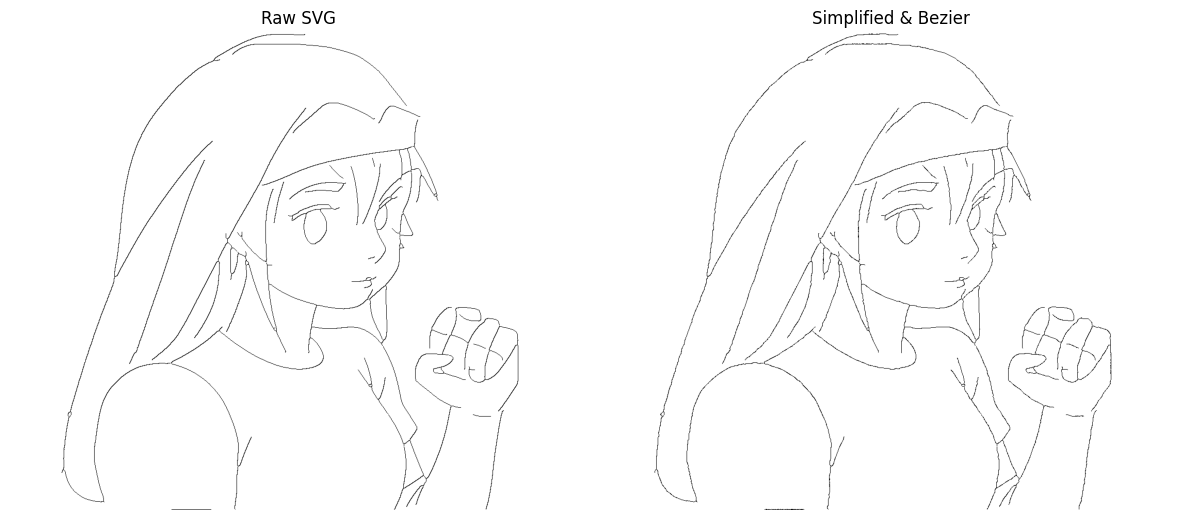


[2/12] SVG Optimization: 41_B
  ✅ Completed in 3.08s (simplify: 2.95s)
  Raw SVG:    Paths: 263, Commands: 11394, Size: 188066 bytes
              M:263, L:11131
  Bezier SVG: Paths: 263, Commands: 1439, Size: 72040 bytes
              M:263, C:1176
  Reduction:  Size: 61.7%, Commands: 87.4%


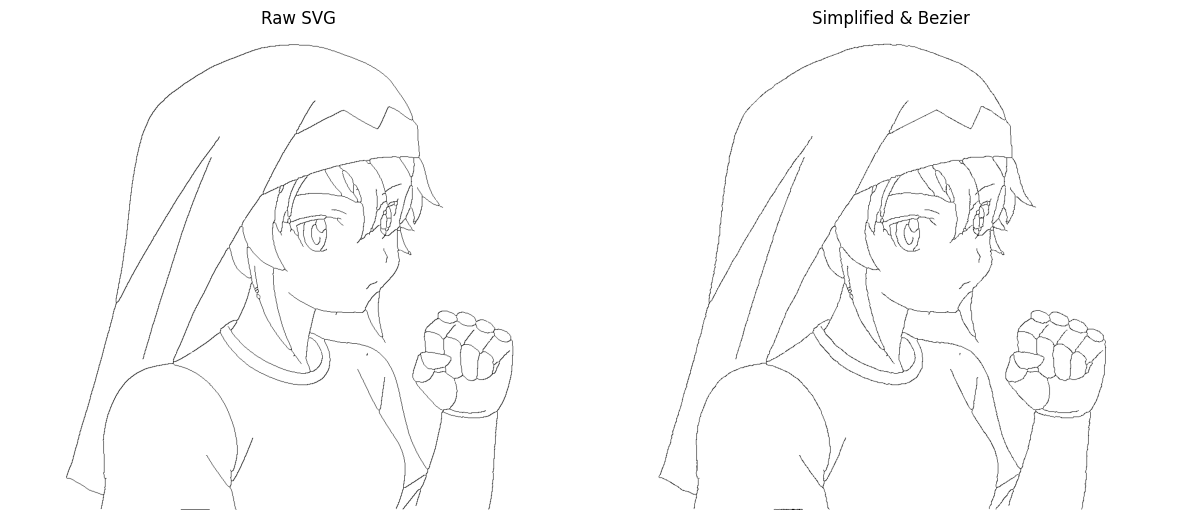


[3/12] SVG Optimization: 65_A
  ✅ Completed in 3.08s (simplify: 2.97s)
  Raw SVG:    Paths: 149, Commands: 11691, Size: 174465 bytes
              M:149, L:11542
  Bezier SVG: Paths: 149, Commands: 1177, Size: 49833 bytes
              M:149, C:1028
  Reduction:  Size: 71.4%, Commands: 89.9%


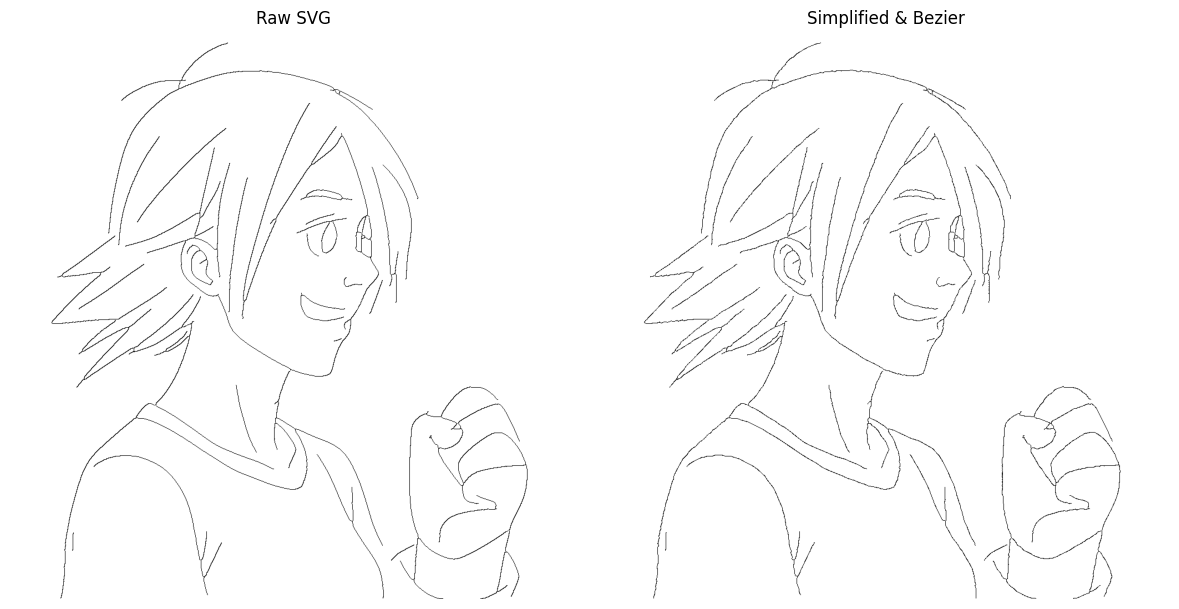


[4/12] SVG Optimization: 65_B
  ✅ Completed in 4.56s (simplify: 3.92s)
  Raw SVG:    Paths: 553, Commands: 17401, Size: 310478 bytes
              M:553, L:16848
  Bezier SVG: Paths: 553, Commands: 2551, Size: 139474 bytes
              M:553, C:1998
  Reduction:  Size: 55.1%, Commands: 85.3%


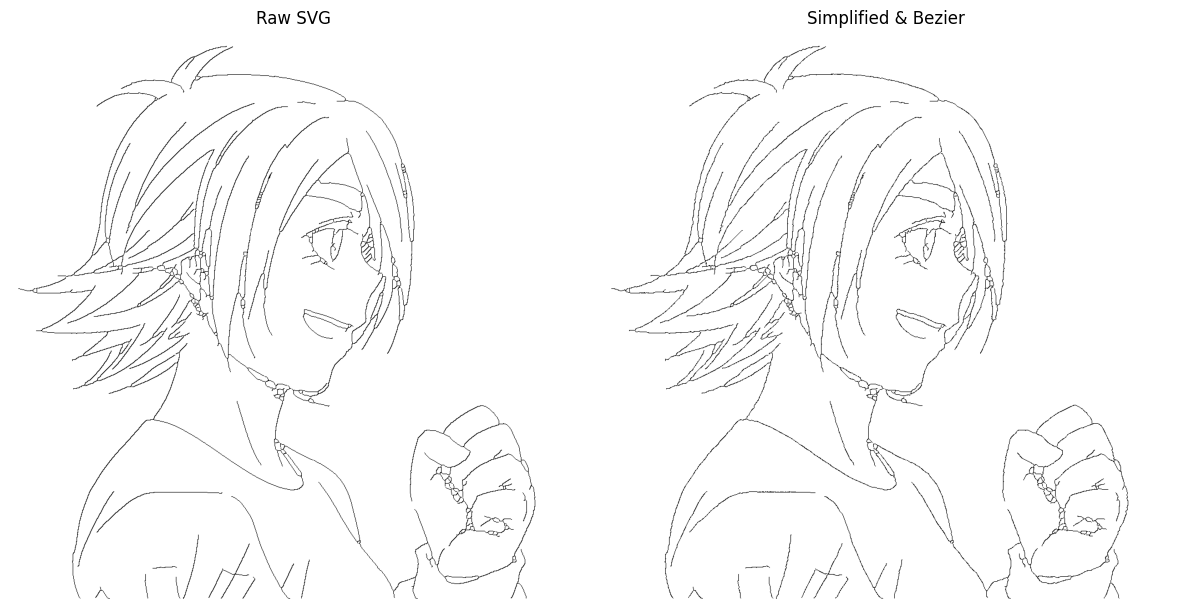


[5/12] SVG Optimization: 153_A
  ✅ Completed in 2.59s (simplify: 2.49s)
  Raw SVG:    Paths: 189, Commands: 10265, Size: 162026 bytes
              M:189, L:10076
  Bezier SVG: Paths: 189, Commands: 1129, Size: 54098 bytes
              M:189, C:940
  Reduction:  Size: 66.6%, Commands: 89.0%


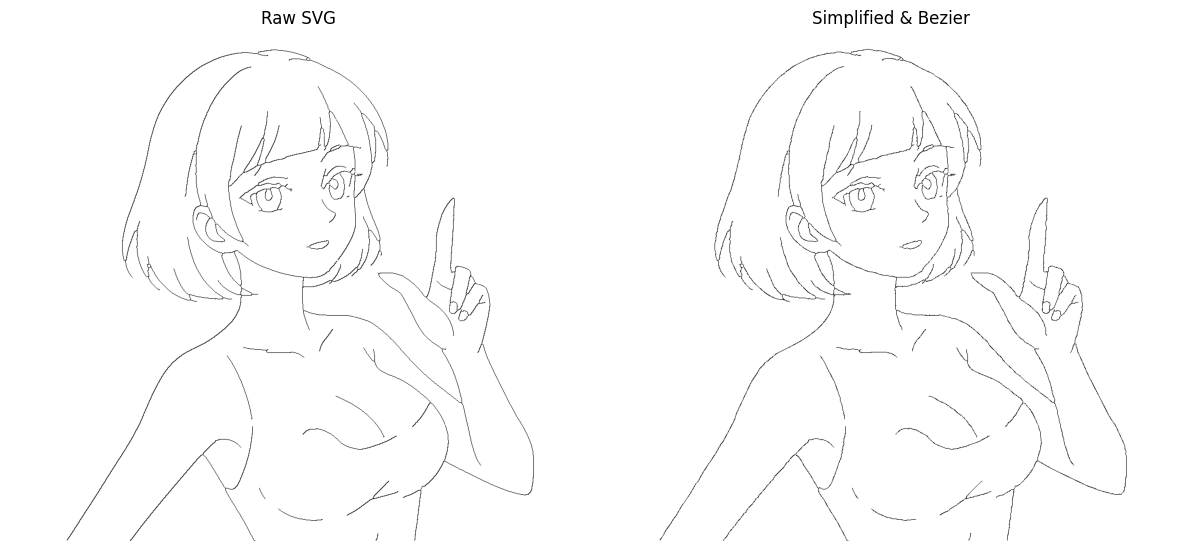


[6/12] SVG Optimization: 153_B
  ✅ Completed in 3.26s (simplify: 3.11s)
  Raw SVG:    Paths: 345, Commands: 13730, Size: 230842 bytes
              M:345, L:13385
  Bezier SVG: Paths: 345, Commands: 1745, Size: 90855 bytes
              M:345, C:1400
  Reduction:  Size: 60.6%, Commands: 87.3%


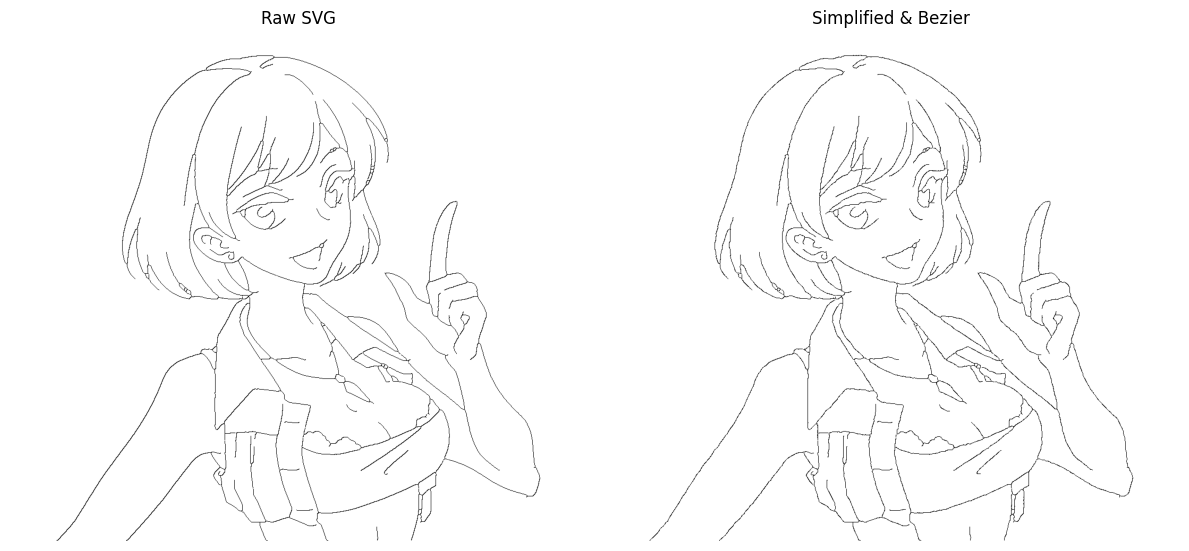


[7/12] SVG Optimization: 254_A
  ✅ Completed in 3.52s (simplify: 3.38s)
  Raw SVG:    Paths: 260, Commands: 12786, Size: 205684 bytes
              M:260, L:12526
  Bezier SVG: Paths: 260, Commands: 1565, Size: 74779 bytes
              M:260, C:1305
  Reduction:  Size: 63.6%, Commands: 87.8%


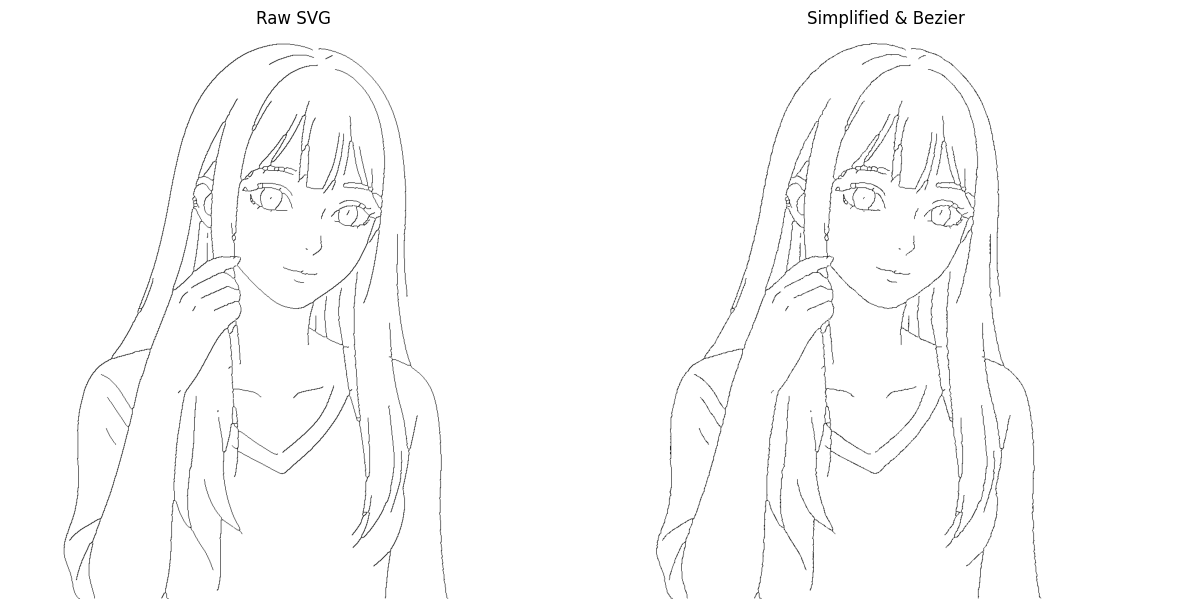


[8/12] SVG Optimization: 254_B
  ✅ Completed in 3.40s (simplify: 3.27s)
  Raw SVG:    Paths: 273, Commands: 12736, Size: 207205 bytes
              M:273, L:12463
  Bezier SVG: Paths: 273, Commands: 1583, Size: 77046 bytes
              M:273, C:1310
  Reduction:  Size: 62.8%, Commands: 87.6%


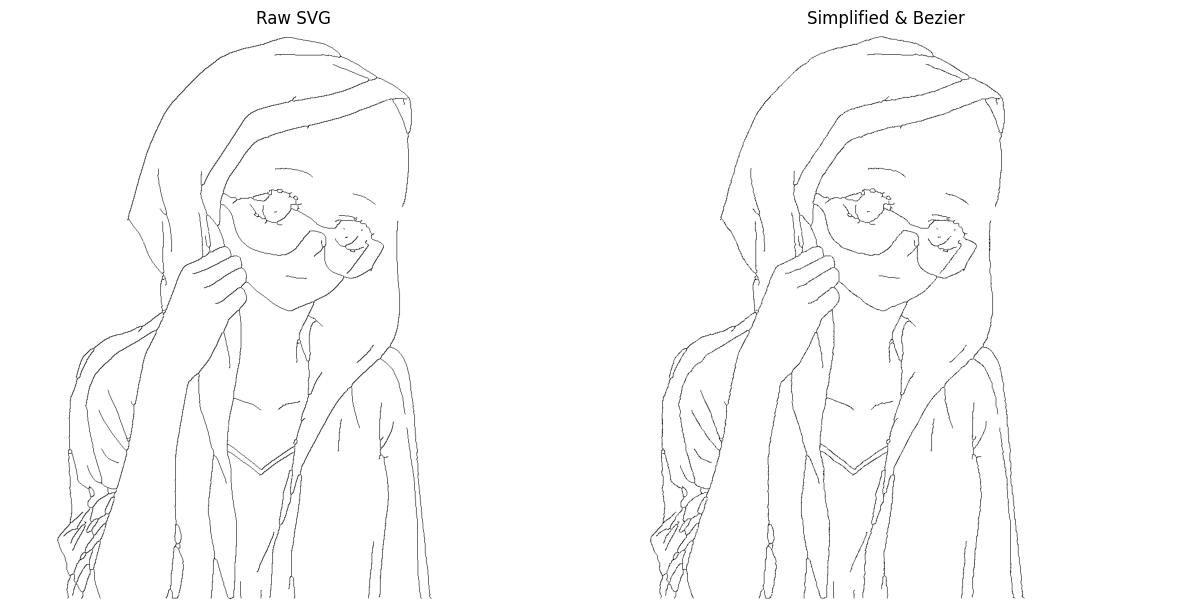


[9/12] SVG Optimization: 710_A
  ✅ Completed in 4.15s (simplify: 4.00s)
  Raw SVG:    Paths: 204, Commands: 15160, Size: 228244 bytes
              M:204, L:14956
  Bezier SVG: Paths: 204, Commands: 1567, Size: 67179 bytes
              M:204, C:1363
  Reduction:  Size: 70.6%, Commands: 89.7%


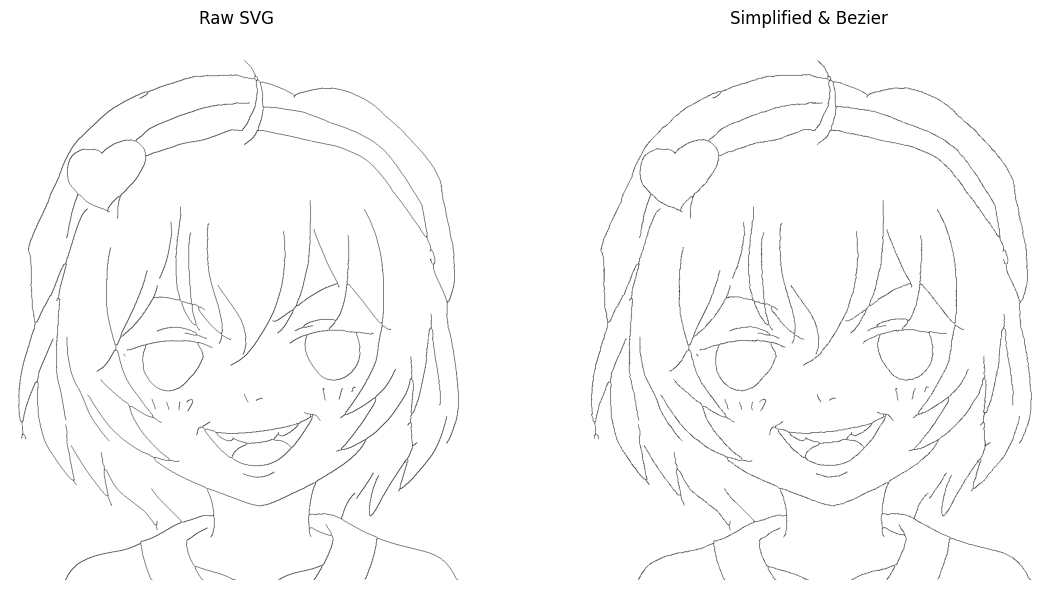


[10/12] SVG Optimization: 710_B
  ✅ Completed in 4.61s (simplify: 4.45s)
  Raw SVG:    Paths: 349, Commands: 17169, Size: 276540 bytes
              M:349, L:16820
  Bezier SVG: Paths: 349, Commands: 2004, Size: 98017 bytes
              M:349, C:1655
  Reduction:  Size: 64.6%, Commands: 88.3%


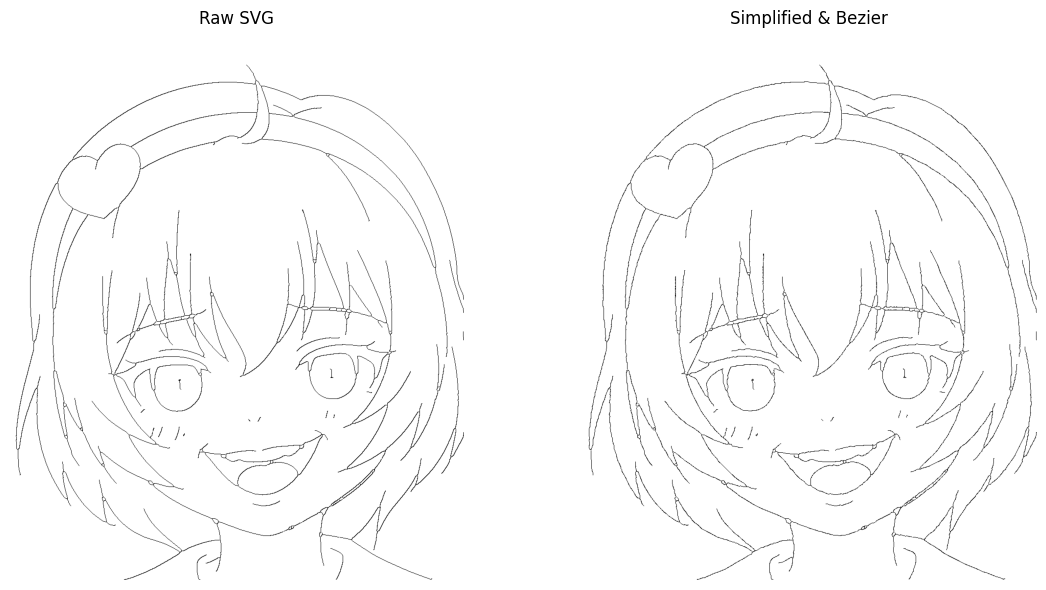


[11/12] SVG Optimization: 1061_A
  ✅ Completed in 3.84s (simplify: 3.28s)
  Raw SVG:    Paths: 216, Commands: 12589, Size: 195975 bytes
              M:216, L:12373
  Bezier SVG: Paths: 216, Commands: 1423, Size: 65053 bytes
              M:216, C:1207
  Reduction:  Size: 66.8%, Commands: 88.7%


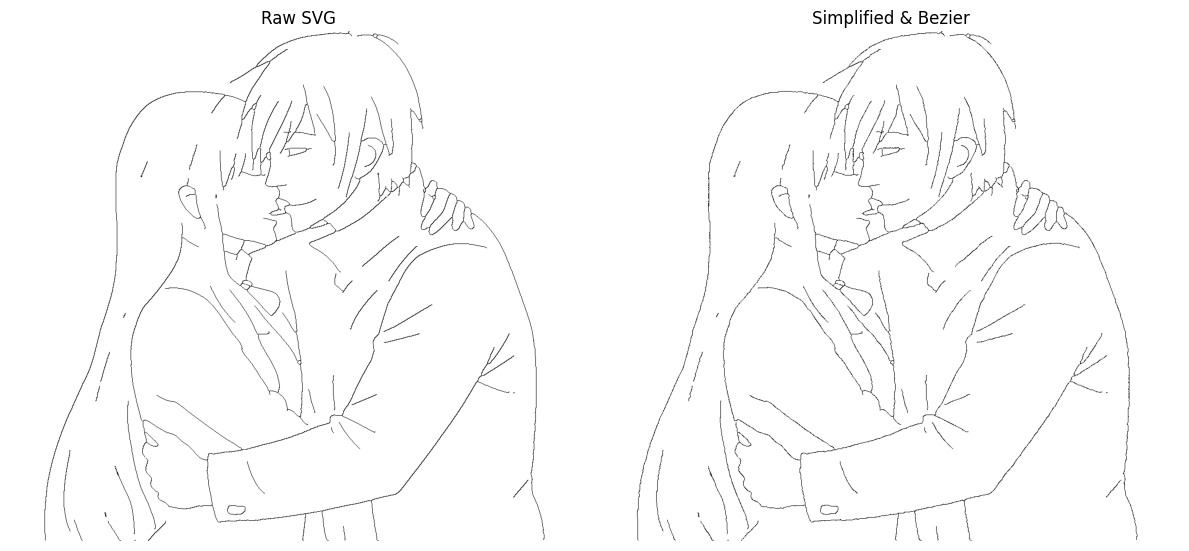


[12/12] SVG Optimization: 1061_B
  ✅ Completed in 4.91s (simplify: 4.74s)
  Raw SVG:    Paths: 494, Commands: 18749, Size: 318296 bytes
              M:494, L:18255
  Bezier SVG: Paths: 494, Commands: 2605, Size: 132576 bytes
              M:494, C:2111
  Reduction:  Size: 58.3%, Commands: 86.1%


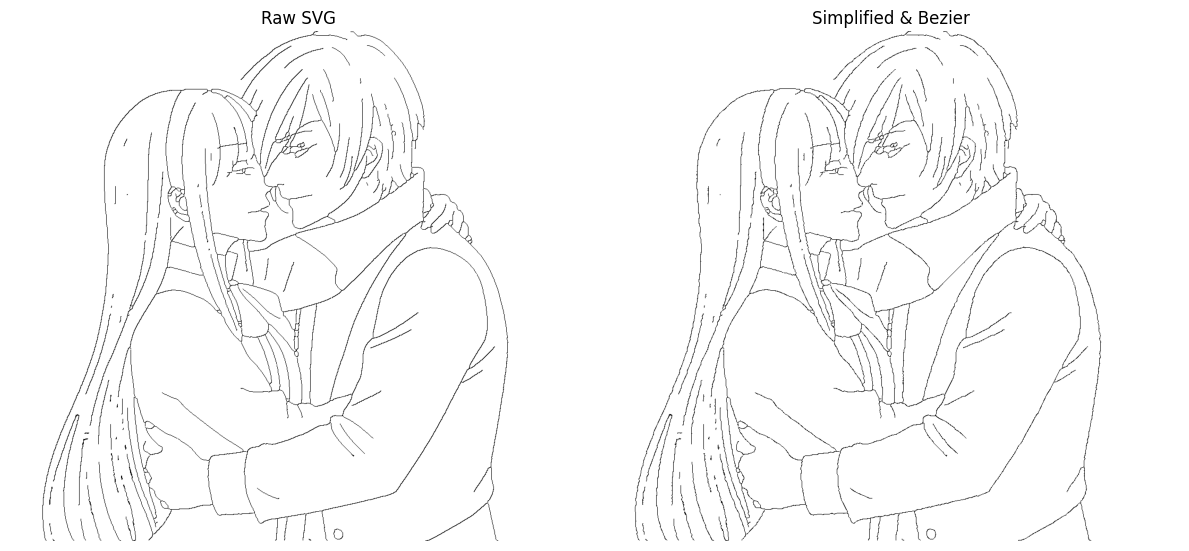


✅ All 12 SVG optimizations completed!
Total time: 56.73s (avg: 4.73s per target)


In [17]:
# ==================== Cell 7: Batch SVG Simplification & Bezier Conversion ====================
import os
import numpy as np
import cv2
import time
import re
from svglib.svg import SVG
from utils.plot_utils import plot_images
from PIL import Image

# Optimization parameters
SIMPLIFY_TOLERANCE = 1.0
EPSILON = 0.5
FORCE_SMOOTH = True
COORDINATE_PRECISION = 0

def count_svg_commands(svg_code):
    """Count different SVG path commands"""
    commands = {
        'M': len(re.findall(r'M\s*[-\d.]+', svg_code)),
        'L': len(re.findall(r'L\s*[-\d.]+', svg_code)),
        'C': len(re.findall(r'C\s*[-\d.]+', svg_code)),
        'Q': len(re.findall(r'Q\s*[-\d.]+', svg_code)),
        'Z': len(re.findall(r'Z', svg_code)),
        'H': len(re.findall(r'H\s*[-\d.]+', svg_code)),
        'V': len(re.findall(r'V\s*[-\d.]+', svg_code)),
        'S': len(re.findall(r'S\s*[-\d.]+', svg_code)),
        'A': len(re.findall(r'A\s*[-\d.]+', svg_code)),
    }
    total = sum(commands.values())
    return commands, total

def get_svg_stats(svg_path, svg_code):
    """Get comprehensive SVG statistics"""
    file_size = os.path.getsize(svg_path)
    num_paths = svg_code.count('<path')
    commands, total_commands = count_svg_commands(svg_code)
    active_commands = {k: v for k, v in commands.items() if v > 0}

    return {
        'file_size': file_size,
        'num_paths': num_paths,
        'total_commands': total_commands,
        'commands': active_commands
    }

def print_svg_comparison(raw_stats, bez_stats):
    """Print comparison between raw and bezier SVG"""
    print(f"  Raw SVG:    Paths: {raw_stats['num_paths']}, Commands: {raw_stats['total_commands']}, Size: {raw_stats['file_size']} bytes")
    raw_cmd_str = ", ".join([f"{k}:{v}" for k, v in raw_stats['commands'].items()])
    print(f"              {raw_cmd_str}")

    print(f"  Bezier SVG: Paths: {bez_stats['num_paths']}, Commands: {bez_stats['total_commands']}, Size: {bez_stats['file_size']} bytes")
    bez_cmd_str = ", ".join([f"{k}:{v}" for k, v in bez_stats['commands'].items()])
    print(f"              {bez_cmd_str}")

    size_reduction = (1 - bez_stats['file_size'] / raw_stats['file_size']) * 100
    cmd_reduction = (1 - bez_stats['total_commands'] / raw_stats['total_commands']) * 100
    print(f"  Reduction:  Size: {size_reduction:.1f}%, Commands: {cmd_reduction:.1f}%")

def render_svg_to_image(svg_file):
    """Render SVG to white background with black lines"""
    svg = SVG.load_svg(svg_file)
    h, w = int(svg.viewbox.wh.y), int(svg.viewbox.wh.x)
    img = np.ones((h, w), dtype=np.uint8) * 255

    for path_group in svg.svg_path_groups:
        for svg_path in path_group.svg_paths:
            points_array = svg_path.sample_points(max_dist=0.5)
            if len(points_array) >= 2:
                points_int = points_array.astype(np.int32)
                cv2.polylines(img, [points_int], isClosed=False, color=0, thickness=1)

    return img

def process_single_target_svg_optimization(target_name):
    """Simplify SVG paths and convert to Bezier curves"""
    target_output_path = f"{OUTPUT_PATH}/{target_name}"
    raw_svg_path = os.path.join(target_output_path, f"{target_name}_5_raw.svg")

    if not os.path.exists(raw_svg_path):
        print(f"  ERROR: Raw SVG not found")
        return None

    step_times = {}

    # Load raw SVG
    t0 = time.time()
    svg = SVG.load_svg(raw_svg_path)
    with open(raw_svg_path, 'r') as f:
        raw_svg_code = f.read()
    raw_stats = get_svg_stats(raw_svg_path, raw_svg_code)
    step_times['load'] = time.time() - t0

    # Simplify and convert to Bezier curves
    t1 = time.time()
    svg.filter_consecutives().filter_duplicates()
    svg.simplify(
        tolerance=SIMPLIFY_TOLERANCE,
        epsilon=EPSILON,
        force_smooth=FORCE_SMOOTH
    )
    step_times['simplify'] = time.time() - t1

    # Save optimized SVG
    t2 = time.time()
    bezier_path = os.path.join(target_output_path, f"{target_name}_6_bezier.svg")
    svg.save_svg(bezier_path, coordinate_precision=COORDINATE_PRECISION)
    with open(bezier_path, 'r') as f:
        bez_svg_code = f.read()
    bez_stats = get_svg_stats(bezier_path, bez_svg_code)
    step_times['save'] = time.time() - t2

    total_time = sum(step_times.values())
    print(f"  ✅ Completed in {total_time:.2f}s (simplify: {step_times['simplify']:.2f}s)")
    print_svg_comparison(raw_stats, bez_stats)

    return {
        'svg': svg,
        'raw_stats': raw_stats,
        'bez_stats': bez_stats
    }

# Batch process all targets
print("="*60)
print("BATCH SVG SIMPLIFICATION & BEZIER CONVERSION")
print("="*60)
print(f"Processing {len(targets)} targets")
print(f"Parameters: tolerance={SIMPLIFY_TOLERANCE}, epsilon={EPSILON}")
print("="*60)

batch_start_time = time.time()

for idx, target_name in enumerate(targets, 1):
    print(f"\n[{idx}/{len(targets)}] SVG Optimization: {target_name}")

    result = process_single_target_svg_optimization(target_name)

    # Visualize each target
    if result is not None:
        raw_path = f"{OUTPUT_PATH}/{target_name}/{target_name}_5_raw.svg"
        bez_path = f"{OUTPUT_PATH}/{target_name}/{target_name}_6_bezier.svg"

        raw_img = render_svg_to_image(raw_path)
        bez_img = render_svg_to_image(bez_path)

        plot_images([
            (Image.fromarray(raw_img), "Raw SVG"),
            (Image.fromarray(bez_img), "Simplified & Bezier")
        ])

batch_total_time = time.time() - batch_start_time

print(f"\n{'='*60}")
print(f"✅ All {len(targets)} SVG optimizations completed!")
print(f"Total time: {batch_total_time:.2f}s (avg: {batch_total_time/len(targets):.2f}s per target)")
print(f"{'='*60}")

In [18]:
# ==================== Cell 8: Batch Bezier Curve Optimization ====================
import os
import cv2
import numpy as np
import time
import re
from svglib.svg import SVG
from utils.plot_utils import plot_images
from PIL import Image

# Optimization parameters
SMOOTH_TENSION = 0.5
SIMPLIFY_TOLERANCE = 2.0
SIMPLIFY_ANGLE_THRESHOLD = 179.5

def count_svg_commands(svg_code):
    """Count different SVG path commands"""
    commands = {
        'M': len(re.findall(r'M\s*[-\d.]+', svg_code)),
        'L': len(re.findall(r'L\s*[-\d.]+', svg_code)),
        'C': len(re.findall(r'C\s*[-\d.]+', svg_code)),
        'Q': len(re.findall(r'Q\s*[-\d.]+', svg_code)),
        'Z': len(re.findall(r'Z', svg_code)),
        'H': len(re.findall(r'H\s*[-\d.]+', svg_code)),
        'V': len(re.findall(r'V\s*[-\d.]+', svg_code)),
        'S': len(re.findall(r'S\s*[-\d.]+', svg_code)),
        'A': len(re.findall(r'A\s*[-\d.]+', svg_code)),
    }
    total = sum(commands.values())
    return commands, total

def get_svg_stats(svg_path, svg_code):
    """Get comprehensive SVG statistics"""
    file_size = os.path.getsize(svg_path)
    num_paths = svg_code.count('<path')
    commands, total_commands = count_svg_commands(svg_code)
    active_commands = {k: v for k, v in commands.items() if v > 0}

    return {
        'file_size': file_size,
        'num_paths': num_paths,
        'total_commands': total_commands,
        'commands': active_commands
    }

def print_svg_optimization_steps(bez_stats, smooth_stats, simp_stats):
    """Print optimization statistics for all three stages"""
    print(f"  Bezier:     Paths: {bez_stats['num_paths']}, Commands: {bez_stats['total_commands']}, Size: {bez_stats['file_size']} bytes")
    bez_cmd_str = ", ".join([f"{k}:{v}" for k, v in bez_stats['commands'].items()])
    print(f"              {bez_cmd_str}")

    print(f"  Smoothed:   Paths: {smooth_stats['num_paths']}, Commands: {smooth_stats['total_commands']}, Size: {smooth_stats['file_size']} bytes")
    smooth_cmd_str = ", ".join([f"{k}:{v}" for k, v in smooth_stats['commands'].items()])
    print(f"              {smooth_cmd_str}")

    print(f"  Simplified: Paths: {simp_stats['num_paths']}, Commands: {simp_stats['total_commands']}, Size: {simp_stats['file_size']} bytes")
    simp_cmd_str = ", ".join([f"{k}:{v}" for k, v in simp_stats['commands'].items()])
    print(f"              {simp_cmd_str}")

    cmd_reduction = (1 - simp_stats['total_commands'] / bez_stats['total_commands']) * 100
    size_reduction = (1 - simp_stats['file_size'] / bez_stats['file_size']) * 100
    print(f"  Total Reduction: Commands: {cmd_reduction:.1f}%, Size: {size_reduction:.1f}%")

def render_svg_to_image(svg_file):
    """Render SVG to white background with black lines"""
    svg = SVG.load_svg(svg_file)
    h, w = int(svg.viewbox.wh.y), int(svg.viewbox.wh.x)
    img = np.ones((h, w), dtype=np.uint8) * 255

    for path_group in svg.svg_path_groups:
        for path in path_group.svg_paths:
            points_array = path.sample_points(max_dist=0.5).astype(np.int32)
            if len(points_array) >= 2:
                cv2.polylines(img, [points_array], isClosed=False, color=0, thickness=1)

    return img

def process_single_target_bezier_optimization(target_name):
    """Smooth and simplify Bezier curves"""
    target_output_path = f"{OUTPUT_PATH}/{target_name}"
    bezier_svg_path = os.path.join(target_output_path, f"{target_name}_6_bezier.svg")

    if not os.path.exists(bezier_svg_path):
        print(f"  ERROR: Bezier SVG not found")
        return None

    step_times = {}

    # Load Bezier SVG
    t0 = time.time()
    svg = SVG.load_svg(bezier_svg_path)
    with open(bezier_svg_path, 'r') as f:
        bez_svg_code = f.read()
    bez_stats = get_svg_stats(bezier_svg_path, bez_svg_code)
    step_times['load'] = time.time() - t0

    # Stage 1: Smooth curves
    t1 = time.time()
    for path_group in svg.svg_path_groups:
        for path in path_group.svg_paths:
            try:
                path.smooth_open(tension=SMOOTH_TENSION)
            except:
                pass

    svg.filter_empty().filter_consecutives()
    step_times['smooth'] = time.time() - t1

    smoothed_path = os.path.join(target_output_path, f"{target_name}_7_smoothed.svg")
    svg.save_svg(smoothed_path, coordinate_precision=0)
    with open(smoothed_path, 'r') as f:
        smooth_svg_code = f.read()
    smooth_stats = get_svg_stats(smoothed_path, smooth_svg_code)

    # Stage 2: Simplify curves
    t2 = time.time()
    for path_group in svg.svg_path_groups:
        for path in path_group.svg_paths:
            try:
                path.simplify(
                    tolerance=SIMPLIFY_TOLERANCE,
                    epsilon=0.05,
                    angle_threshold=SIMPLIFY_ANGLE_THRESHOLD,
                    force_smooth=False
                )
            except:
                pass

    svg.filter_empty().filter_consecutives()
    step_times['simplify'] = time.time() - t2

    simplified_path = os.path.join(target_output_path, f"{target_name}_8_simplified.svg")
    svg.save_svg(simplified_path, coordinate_precision=0)
    with open(simplified_path, 'r') as f:
        simp_svg_code = f.read()
    simp_stats = get_svg_stats(simplified_path, simp_svg_code)

    total_time = sum(step_times.values())
    print(f"  ✅ Completed in {total_time:.2f}s (smooth: {step_times['smooth']:.2f}s, simplify: {step_times['simplify']:.2f}s)")
    print_svg_optimization_steps(bez_stats, smooth_stats, simp_stats)

    return {
        'svg': svg,
        'bez_stats': bez_stats,
        'smooth_stats': smooth_stats,
        'simp_stats': simp_stats
    }

# Batch process all targets
print("="*60)
print("BATCH BEZIER CURVE OPTIMIZATION")
print("="*60)
print(f"Processing {len(targets)} targets")
print(f"Parameters: tension={SMOOTH_TENSION}, tolerance={SIMPLIFY_TOLERANCE}")
print("="*60)

batch_start_time = time.time()

for idx, target_name in enumerate(targets, 1):
    print(f"\n[{idx}/{len(targets)}] Bezier Optimization: {target_name}")

    result = process_single_target_bezier_optimization(target_name)

    # Visualize each target
    if result is not None:
        bez_path = f"{OUTPUT_PATH}/{target_name}/{target_name}_6_bezier.svg"
        smoothed_path = f"{OUTPUT_PATH}/{target_name}/{target_name}_7_smoothed.svg"
        simplified_path = f"{OUTPUT_PATH}/{target_name}/{target_name}_8_simplified.svg"

        bez_img = render_svg_to_image(bez_path)
        smoothed_img = render_svg_to_image(smoothed_path)
        simplified_img = render_svg_to_image(simplified_path)

        plot_images([
            (Image.fromarray(bez_img), "Bezier"),
            (Image.fromarray(smoothed_img), "Smoothed"),
            (Image.fromarray(simplified_img), "Simplified")
        ])

batch_total_time = time.time() - batch_start_time

print(f"\n{'='*60}")
print(f"✅ All {len(targets)} Bezier optimizations completed!")
print(f"Total time: {batch_total_time:.2f}s (avg: {batch_total_time/len(targets):.2f}s per target)")
print(f"{'='*60}")

Output hidden; open in https://colab.research.google.com to view.

In [19]:
# ==================== Cell: Convert Output to LaTeX-friendly Format ====================
import os
import shutil
from PIL import Image
from utils.image_utils import svg_code_to_pil_image
from svglib.svg import SVG

# Paths
OUTPUT_FOR_TEX = f"{PROJECT_PATH}/output_for_tex"

def convert_svg_to_png(svg_path, output_png_path):
    """Convert SVG file to PNG"""
    try:
        svg = SVG.load_svg(svg_path)
        with open(svg_path, 'r') as f:
            svg_code = f.read()

        h, w = int(svg.viewbox.wh.y), int(svg.viewbox.wh.x)
        png_image = svg_code_to_pil_image(svg_code, width=w, height=h)
        png_image.save(output_png_path)
        return True
    except Exception as e:
        print(f"    ERROR converting {os.path.basename(svg_path)}: {str(e)}")
        return False

def process_target_for_tex(target_name):
    """Process a single target: copy PNGs and convert SVGs to PNGs"""
    source_dir = f"{OUTPUT_PATH}/{target_name}"
    target_dir = f"{OUTPUT_FOR_TEX}/{target_name}"

    if not os.path.exists(source_dir):
        print(f"  ERROR: Source directory not found: {target_name}")
        return

    # Create target directory
    os.makedirs(target_dir, exist_ok=True)

    files = os.listdir(source_dir)
    png_count = 0
    svg_count = 0

    for filename in files:
        source_path = os.path.join(source_dir, filename)

        if filename.endswith('.png'):
            # Copy PNG directly
            target_path = os.path.join(target_dir, filename)
            shutil.copy2(source_path, target_path)
            png_count += 1

        elif filename.endswith('.svg'):
            # Convert SVG to PNG
            base_name = filename[:-4]  # Remove .svg
            target_filename = f"{base_name}_svg.png"
            target_path = os.path.join(target_dir, target_filename)

            if convert_svg_to_png(source_path, target_path):
                svg_count += 1

    print(f"  ✅ Processed: {png_count} PNGs copied, {svg_count} SVGs converted")

# Create output directory
print("="*60)
print("CONVERT OUTPUT TO LATEX-FRIENDLY FORMAT")
print("="*60)
print(f"Source: {OUTPUT_PATH}")
print(f"Target: {OUTPUT_FOR_TEX}")
print("="*60)

if os.path.exists(OUTPUT_FOR_TEX):
    print(f"Removing existing directory: {OUTPUT_FOR_TEX}")
    shutil.rmtree(OUTPUT_FOR_TEX)

os.makedirs(OUTPUT_FOR_TEX)
print(f"Created directory: {OUTPUT_FOR_TEX}\n")

# Process all targets
for idx, target_name in enumerate(targets, 1):
    print(f"[{idx}/{len(targets)}] Processing: {target_name}")
    process_target_for_tex(target_name)

print(f"\n{'='*60}")
print(f"✅ All {len(targets)} targets processed!")
print(f"Output ready for LaTeX at: {OUTPUT_FOR_TEX}")
print(f"{'='*60}")

CONVERT OUTPUT TO LATEX-FRIENDLY FORMAT
Source: /content/drive/MyDrive/SVGEditor/output
Target: /content/drive/MyDrive/SVGEditor/output_for_tex
Removing existing directory: /content/drive/MyDrive/SVGEditor/output_for_tex
Created directory: /content/drive/MyDrive/SVGEditor/output_for_tex

[1/12] Processing: 41_A
  ✅ Processed: 9 PNGs copied, 4 SVGs converted
[2/12] Processing: 41_B
  ✅ Processed: 9 PNGs copied, 4 SVGs converted
[3/12] Processing: 65_A
  ✅ Processed: 9 PNGs copied, 4 SVGs converted
[4/12] Processing: 65_B
  ✅ Processed: 9 PNGs copied, 4 SVGs converted
[5/12] Processing: 153_A
  ✅ Processed: 9 PNGs copied, 4 SVGs converted
[6/12] Processing: 153_B
  ✅ Processed: 9 PNGs copied, 5 SVGs converted
[7/12] Processing: 254_A
  ✅ Processed: 9 PNGs copied, 4 SVGs converted
[8/12] Processing: 254_B
  ✅ Processed: 9 PNGs copied, 4 SVGs converted
[9/12] Processing: 710_A
  ✅ Processed: 9 PNGs copied, 4 SVGs converted
[10/12] Processing: 710_B
  ✅ Processed: 9 PNGs copied, 4 SVGs conv

In [3]:
# ==================== Cell 8: Batch Bezier Curve Optimization ====================
import os
import time
from svglib.svg import SVG

# Optimization parameters
SMOOTH_TENSION = 0.5
SIMPLIFY_TOLERANCE = 2.0
SIMPLIFY_ANGLE_THRESHOLD = 179.5

def process_single_target_bezier_optimization(target_name):
    """Smooth and simplify Bezier curves - extract timing only"""
    target_output_path = f"{OUTPUT_PATH}/{target_name}"
    bezier_svg_path = os.path.join(target_output_path, f"{target_name}_6_bezier.svg")

    if not os.path.exists(bezier_svg_path):
        print(f"  ❌ Bezier SVG not found")
        return None

    step_times = {}

    # Load Bezier SVG
    t0 = time.time()
    svg = SVG.load_svg(bezier_svg_path)
    step_times['load'] = time.time() - t0

    # Stage 1: Smooth curves
    t1 = time.time()
    for path_group in svg.svg_path_groups:
        for path in path_group.svg_paths:
            try:
                path.smooth_open(tension=SMOOTH_TENSION)
            except:
                pass

    svg.filter_empty().filter_consecutives()
    step_times['smooth'] = time.time() - t1

    # Save smoothed SVG
    smoothed_path = os.path.join(target_output_path, f"{target_name}_7_smoothed.svg")
    svg.save_svg(smoothed_path, coordinate_precision=0)

    # Stage 2: Simplify curves
    t2 = time.time()
    for path_group in svg.svg_path_groups:
        for path in path_group.svg_paths:
            try:
                path.simplify(
                    tolerance=SIMPLIFY_TOLERANCE,
                    epsilon=0.05,
                    angle_threshold=SIMPLIFY_ANGLE_THRESHOLD,
                    force_smooth=False
                )
            except:
                pass

    svg.filter_empty().filter_consecutives()
    step_times['simplify'] = time.time() - t2

    # Save simplified SVG
    simplified_path = os.path.join(target_output_path, f"{target_name}_8_simplified.svg")
    svg.save_svg(simplified_path, coordinate_precision=0)

    total_time = sum(step_times.values())
    print(f"  ✅ Completed in {total_time:.2f}s (load: {step_times['load']:.2f}s, smooth: {step_times['smooth']:.2f}s, simplify: {step_times['simplify']:.2f}s)")

    return step_times

# Batch process all targets
print("="*60)
print("BATCH BEZIER CURVE OPTIMIZATION")
print("="*60)
print(f"Processing {len(targets)} targets")
print(f"Parameters: tension={SMOOTH_TENSION}, tolerance={SIMPLIFY_TOLERANCE}")
print("="*60)

batch_start_time = time.time()
all_step_times = []

for idx, target_name in enumerate(targets, 1):
    print(f"\n[{idx}/{len(targets)}] Bezier Optimization: {target_name}")

    step_times = process_single_target_bezier_optimization(target_name)

    if step_times:
        all_step_times.append(step_times)

batch_total_time = time.time() - batch_start_time

# Calculate average times
if all_step_times:
    avg_load = sum(t['load'] for t in all_step_times) / len(all_step_times)
    avg_smooth = sum(t['smooth'] for t in all_step_times) / len(all_step_times)
    avg_simplify = sum(t['simplify'] for t in all_step_times) / len(all_step_times)
    avg_total = sum(sum(t.values()) for t in all_step_times) / len(all_step_times)

    print(f"\n{'='*60}")
    print("TIMING SUMMARY")
    print(f"{'='*60}")
    print(f"Load time:      {avg_load:.2f}s")
    print(f"Smooth time:    {avg_smooth:.2f}s")
    print(f"Simplify time:  {avg_simplify:.2f}s")
    print(f"Total time:     {avg_total:.2f}s")
    print(f"Batch total:    {batch_total_time:.2f}s (avg: {batch_total_time/len(targets):.2f}s per target)")
    print(f"{'='*60}")

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':



BATCH BEZIER CURVE OPTIMIZATION
Processing 12 targets
Parameters: tension=0.5, tolerance=2.0

[1/12] Bezier Optimization: 41_A
  ✅ Completed in 1.11s (load: 0.61s, smooth: 0.08s, simplify: 0.42s)

[2/12] Bezier Optimization: 41_B
  ✅ Completed in 1.29s (load: 0.55s, smooth: 0.10s, simplify: 0.64s)

[3/12] Bezier Optimization: 65_A
  ✅ Completed in 1.27s (load: 0.63s, smooth: 0.10s, simplify: 0.55s)

[4/12] Bezier Optimization: 65_B
  ✅ Completed in 1.91s (load: 0.71s, smooth: 0.17s, simplify: 1.03s)

[5/12] Bezier Optimization: 153_A
  ✅ Completed in 1.11s (load: 0.58s, smooth: 0.08s, simplify: 0.45s)

[6/12] Bezier Optimization: 153_B
  ✅ Completed in 1.41s (load: 0.62s, smooth: 0.12s, simplify: 0.68s)

[7/12] Bezier Optimization: 254_A
  ✅ Completed in 1.52s (load: 0.65s, smooth: 0.12s, simplify: 0.75s)

[8/12] Bezier Optimization: 254_B
  ✅ Completed in 1.36s (load: 0.45s, smooth: 0.12s, simplify: 0.79s)

[9/12] Bezier Optimization: 710_A
  ✅ Completed in 1.40s (load: 0.56s, smooth: